# Softmax for image classification


This project will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from lib.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'lib/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **lib/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file lib/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from lib.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.381532
sanity check: 2.302585


We expect our loss to be close to -log(0.1) because normalized score of each class is 0.1 (as we have 10 classes with score 1 => normalized 1/10 = 0.1)

Substitution this to the equation will give -log(0.1)


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from lib.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.489530 analytic: 0.489530, relative error: 1.896842e-07
numerical: -1.068705 analytic: -1.068705, relative error: 1.870362e-08
numerical: -1.415283 analytic: -1.415283, relative error: 1.785929e-08
numerical: -0.719474 analytic: -0.719474, relative error: 1.965880e-08
numerical: -1.807850 analytic: -1.807850, relative error: 9.321399e-10
numerical: -0.807122 analytic: -0.807122, relative error: 5.437000e-08
numerical: -1.581607 analytic: -1.581607, relative error: 2.133172e-08
numerical: 0.442568 analytic: 0.442568, relative error: 3.695555e-08
numerical: -2.611682 analytic: -2.611682, relative error: 9.339128e-09
numerical: -0.074111 analytic: -0.074111, relative error: 5.502026e-07
numerical: 4.680098 analytic: 4.686033, relative error: 6.335866e-04
numerical: -1.199792 analytic: -1.200407, relative error: 2.560824e-04
numerical: 1.375394 analytic: 1.377290, relative error: 6.890020e-04
numerical: 5.341315 analytic: 5.352887, relative error: 1.082085e-03
numerical: -2.12

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from lib.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.381532e+00 computed in 0.114833s
scores  [[ 0.09697543 -0.64613019  0.68663382 ...  0.51428879  0.44797909
   0.30586436]
 [ 0.34275339 -0.04352948  0.4460806  ...  0.25524935  0.26100841
   0.0591023 ]
 [-1.35956434  0.08050167 -0.10964873 ... -0.14299128 -0.05970801
  -0.97723723]
 ...
 [ 0.35061262 -0.25144207 -0.04219318 ...  0.24556019  0.43856607
  -0.21529867]
 [ 0.09737512  0.24140466  0.10329241 ... -0.29409749 -0.32877662
   0.24535517]
 [-0.23354787 -0.29368128 -0.20880478 ... -0.11053363 -0.58496863
   0.34956273]]
vectorized loss: 2.381532e+00 computed in 0.007613s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You can experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy close to 0.35 on the validation set.
from lib.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

# Use the validation set to set the learning rate and regularization strength.
# This is almost identical to the validation that we used for the SVM; save   
# the best trained softmax classifer in best_softmax.                         
grid_search=[(x,y) for x in learning_rates for y in regularization_strengths]

for lr, reg in grid_search:
    softmax=Softmax()
    softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1000)
    y_train_pred=softmax.predict(X_train)
    y_val_pred=softmax.predict(X_val)
    train_accuracy=np.mean(y_train_pred==y_train)
    val_accuracy=np.mean(y_val_pred==y_val)
    
    results[lr, reg] = (train_accuracy, val_accuracy)
    
    if val_accuracy > best_val:
        best_val=val_accuracy
        best_softmax=softmax
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % 
                       (lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

scores  [[ 6.63836004  4.56610339 -6.79995802 ...  0.10569455  2.75417947
   1.87297596]
 [-1.42773522 -4.68722533  4.07526706 ...  0.09831912  5.74281627
  -3.0808248 ]
 [-6.69770987 -0.77526352  6.57240448 ...  4.55516649  1.87871164
  -4.91616238]
 ...
 [-6.07392935  3.02299301  0.49684219 ...  0.31400153  0.0834445
  -3.3994521 ]
 [-3.96954858  1.91063365  1.4849213  ...  0.96326128  4.52650056
  -0.11032319]
 [-5.45703977 -4.68348823  7.9807131  ...  4.38882035  3.82996274
   7.07737688]]
scores  [[-1.48403883  0.92310852  0.95730822 ... -2.79177334  0.36091135
  -1.5386286 ]
 [ 0.12420513 -0.74706604  3.55759653 ... -0.99500592 -0.65760435
   2.27209381]
 [-0.61937578  0.76445489 10.19492036 ...  1.88974228  5.4398918
   7.52483892]
 ...
 [-1.80654004 -3.74460905 -2.04543883 ... -1.14309743 -4.46974151
   2.29570436]
 [ 5.65760867  1.05122101 -5.75009914 ... -2.84411908 -1.0851726
  -4.55998825]
 [ 5.26636066  4.18068121 -4.88170548 ... -3.83988667 -4.610601
   2.78489028]]
score

scores  [[-3.95258644 -0.94616142  2.19018748 ... -0.75091529  0.3095938
  -0.83240648]
 [-0.66058094  1.26990231 -6.02319551 ... -1.03875112 -3.15815058
  -2.30827269]
 [ 0.08149472 -6.00102032 -0.52598151 ... -1.56409425  4.76165635
   5.45937303]
 ...
 [-4.55873377 -0.99333143  0.63793779 ...  2.1726323  -3.53684497
   0.01287759]
 [-0.641782   -0.85981571  0.05113487 ... -2.68007801 -4.21798206
   3.14755365]
 [ 7.58042967  2.795462   -1.73039437 ... -0.16727755 -1.04016765
   0.48034479]]
scores  [[-0.39542998  1.01249593 -0.44377722 ...  2.79184212 -1.72131814
  -1.34195112]
 [-3.50714262 -1.52654153 -5.13547535 ... -1.14237888 -6.478985
  -1.002293  ]
 [ 2.96690832  3.02619755 -1.87089197 ...  0.15219837 -3.28046445
  -0.93387168]
 ...
 [ 5.68994711 -2.86122844 -0.72156919 ... -0.82846795  0.8074277
   5.13682639]
 [ 2.73910159  1.20438332 -0.55337688 ... -0.4329235   0.31988454
   0.85409312]
 [ 3.62556464  0.50361343 -3.44312171 ...  0.83914893  0.11861081
  -4.26968883]]
scor

scores  [[-2.32594101  0.95340741 -0.16506216 ... -2.95299355 -4.89366451
  -2.15205599]
 [ 0.81986956  0.54988495 -2.07901619 ...  0.32581232 -1.12983147
  -1.51322584]
 [ 0.77669909 -0.47871935  2.89125796 ...  0.57932773 -1.16081691
  -2.18044392]
 ...
 [ 5.00195816 -0.28676005 -2.33019895 ...  0.42518558  0.12954666
   2.25092119]
 [-1.27425556 -1.40795646  3.61952007 ... -2.69754112 -0.52393171
   2.63744042]
 [ 4.40527378 -2.31542608 -3.36846645 ... -0.02534097  1.35544133
  -0.09774291]]
scores  [[ 2.51776069e+00  1.94596826e+00 -1.00640422e+00 ...  1.38604550e+00
  -3.09756691e+00 -2.05032212e+00]
 [ 1.32001976e+00  3.26909080e-01  2.70299513e-02 ...  2.12320334e+00
   1.58385801e-01  1.49337049e+00]
 [ 3.43860258e+00 -1.24587383e+00 -1.33011846e+00 ... -3.87587742e+00
   2.52030881e-01 -1.62727687e-01]
 ...
 [-2.13595633e-01 -9.07518687e-03 -1.90920988e+00 ...  1.40419377e+00
  -5.13104020e+00 -3.21289663e+00]
 [ 2.61140743e+00  3.20639652e+00 -1.80000787e+00 ... -2.31808208e+

scores  [[ 1.98976795 -3.44124586  3.09779728 ...  0.08019393 -0.51039066
   1.94516407]
 [-0.11080911  1.91981272  0.73004962 ... -0.14467791  0.01135239
   1.48531982]
 [-0.13960666  0.37140304  0.11935969 ... -3.78538534  2.17686724
  -0.38393499]
 ...
 [-2.91682203 -1.11197832  1.23731828 ... -2.48957918 -1.86904858
  -0.11009651]
 [-2.05672984  1.12715562  0.13690806 ... -0.09065012 -2.73532183
  -0.86818282]
 [ 2.13339015 -0.63909384 -1.54354391 ... -0.65563752  2.6965063
  -3.36323968]]
scores  [[-4.25136151  0.82818254 -1.38491927 ...  0.71739003 -1.34429945
   0.91770097]
 [-2.44036512 -1.15687242  0.63418888 ...  0.46874013 -1.71376225
  -1.47379856]
 [-0.51166244 -0.26787773  0.37304667 ...  2.0917953  -2.14016779
   3.19571368]
 ...
 [-1.776065   -0.21767224  4.24295348 ... -2.57391208 -0.00451978
   0.41479355]
 [-1.36389031  1.77923641  2.27807006 ...  1.68220979 -1.92722965
  -0.34669039]
 [-1.32206769  1.17920389 -1.12597584 ... -1.59711932  1.08237609
  -2.76175404]]
s

scores  [[-1.19716118 -0.09856219  2.24836727 ... -0.35987263 -1.25940283
   1.20078266]
 [ 3.66972589  0.33270123  1.88550844 ...  0.1875777   0.33448873
   3.94360454]
 [ 0.58821403  0.53863055 -1.95089217 ... -0.37384258  0.05740313
  -1.17273267]
 ...
 [-0.21144572  0.8095319  -0.88335831 ...  1.39778636 -0.06734089
  -0.91100886]
 [ 1.46247401  0.45259644  0.16676988 ... -1.02194607  2.12691232
   1.457987  ]
 [ 4.48371893  2.26991083  1.32925736 ...  0.77709741 -0.59390771
  -0.49133563]]
scores  [[-0.27779715 -1.68470796 -1.57057994 ...  1.15142476 -1.31084937
   0.94359709]
 [ 1.67860328  0.85634162 -1.47843762 ... -1.0363016  -0.41519577
  -2.25948617]
 [-3.81214286 -2.70771041  0.29846034 ...  0.06901495  1.46777502
   1.89395313]
 ...
 [ 1.18451515  3.88805421 -0.59067466 ... -2.50397378 -2.10768577
   0.80008032]
 [ 0.09298488  0.4013062  -1.42084964 ... -0.76593636  2.26756189
   0.84295812]
 [ 3.58096    -2.56694434  1.21103423 ... -2.37827247  2.75128205
   0.51292049]]


scores  [[-0.72520943 -0.37665666 -2.36666942 ... -0.7416961  -0.03709617
  -1.66864255]
 [ 0.88173983 -0.45098226  1.70765664 ... -0.0648116   0.01931737
  -0.75715602]
 [-4.74644906 -2.16512671  0.07493081 ... -1.68687732 -2.53483489
   1.09676216]
 ...
 [-0.51137793  0.9754506  -0.33559528 ... -2.32388068  3.45869045
   2.70335736]
 [-2.65494924 -1.12493621  0.58968688 ...  1.69605754 -0.16069018
  -1.40532663]
 [-0.14274733 -0.39745378 -1.4800747  ... -1.18149114 -0.62429674
   0.77355963]]
scores  [[-4.16617763e+00  9.78318005e-01 -3.96654173e-01 ... -6.17980191e-01
  -5.66185842e-01 -1.38854915e+00]
 [ 6.79859288e-01  1.89079082e+00  8.70382184e-01 ... -5.56925968e-01
  -2.56527917e-01 -5.51682401e-01]
 [ 2.26279042e+00  4.60385851e-01 -3.08170635e-01 ...  8.89542750e-01
   4.61928492e-01  1.02283170e+00]
 ...
 [-8.62918383e-01  8.60759049e-01  6.98844994e-01 ... -8.81861373e-01
  -1.98526301e+00 -1.44068934e-01]
 [-2.44159030e+00  2.91362512e-01 -4.61023134e-01 ...  2.39149013e-

scores  [[ 0.35911029  1.59618749 -0.25840848 ... -0.50529329 -0.81126531
  -0.84886435]
 [-1.56682231 -1.0928849  -0.41820664 ...  0.4248454  -2.40940612
  -0.1839023 ]
 [ 3.37122025  0.2542711   2.13410283 ...  1.29542178  2.74108029
   0.62219624]
 ...
 [ 1.24920188 -1.28496008 -2.23732057 ... -1.99490788  1.12000762
   0.9773063 ]
 [-0.22840086  0.27108338  0.52215507 ... -0.08991004 -1.2547081
   0.67845278]
 [ 1.93127864  0.80068743  0.69782259 ...  0.08170534 -0.81363392
  -0.49620393]]
scores  [[ 1.38876508e+00  7.04661849e-01 -6.58502439e-02 ... -9.70490417e-01
   2.50471766e+00 -1.05645088e+00]
 [ 2.81624051e-01 -1.65221096e+00  6.36067709e-01 ...  7.26278490e-01
  -5.88265628e-01 -2.15264047e-01]
 [ 8.15399350e-02  1.65166559e+00 -1.52723874e+00 ... -2.69216836e+00
  -1.92025218e+00 -7.52900265e-01]
 ...
 [-1.55800464e+00 -6.38582010e-01 -1.19119949e+00 ...  3.74967822e-03
   4.19243143e+00 -1.63609576e+00]
 [ 7.32382254e-01 -9.06038848e-01  2.97497030e-01 ... -4.18393779e-0

scores  [[ 0.08616881  0.86728746  0.20804732 ...  0.09156881  0.85912351
   0.54378428]
 [-1.16376857  0.64857953  0.57045257 ... -0.53720384  0.32513901
  -0.57392287]
 [ 3.35957241  0.24749254 -1.23748418 ... -1.24519406  0.99228762
   0.56478814]
 ...
 [ 1.78694313  1.30032425  1.05439468 ...  0.40079752  0.87568131
  -0.16037532]
 [ 2.85530473  0.9142585   1.64595361 ...  0.92008001  3.03203949
   0.38798624]
 [ 1.49037715 -0.33246975 -0.39706869 ... -1.14243338  0.95782488
   0.60312015]]
scores  [[ 0.63062916 -0.24507776  1.72615661 ...  1.26026765 -1.55499924
   0.28984573]
 [ 0.03428501 -1.28918924 -0.23674398 ...  0.09280568  0.17737769
   2.47032161]
 [-0.19571232  2.22150608 -2.3091383  ... -1.04094907  1.42678499
   2.48390048]
 ...
 [-0.17401607 -0.99652956 -1.33292578 ...  0.75262655 -0.10593472
   0.89969659]
 [ 1.10753625  0.48090915 -0.20778826 ... -1.33108021  0.55799837
   0.28574265]
 [ 2.30814682  1.19737613  0.4619578  ...  1.81791186  4.50082003
   1.68895636]]


scores  [[ 1.55969017e+00 -9.74482943e-01  3.00228171e+00 ...  1.57852888e+00
   1.05031921e+00 -8.19061388e-01]
 [-2.95161013e+00 -1.97774821e+00 -4.41320806e-01 ... -7.64664328e-01
  -2.83416985e+00  9.33854194e-02]
 [-2.14738192e+00 -6.95630845e-01 -2.57779322e-01 ...  3.81902402e-03
  -1.26978545e-01 -3.25491733e-01]
 ...
 [-5.54894012e-01  7.25226432e-01 -5.48753588e-01 ... -1.78822355e-01
   2.64067418e+00 -1.50814604e-01]
 [ 2.42322557e+00  1.45920974e+00 -4.21053207e+00 ... -1.86546341e+00
   1.27641425e+00 -4.02297469e-01]
 [-2.44650296e+00 -2.33386757e+00 -1.01321121e+00 ... -8.09959029e-01
   3.02008703e-02  2.36651133e+00]]
scores  [[-1.14786076 -0.37430359  0.478237   ...  0.16581067 -0.81315137
  -0.63542953]
 [-0.20661492  0.27907112  0.0375842  ... -0.52920976 -0.56083466
  -0.56957492]
 [ 1.39052155 -0.75838556 -0.83618096 ... -0.0423568  -0.66308858
   1.45845012]
 ...
 [ 1.01162662  0.42577638  1.97387244 ...  2.00885907  0.23636971
   0.39318848]
 [-0.26879831 -0.41

scores  [[ 2.73961984 -1.13799512  0.22124498 ... -0.23717668 -1.9361334
   1.9059132 ]
 [-0.53053803 -0.09650147 -2.0034307  ... -0.80461915 -0.42009877
   1.10355609]
 [ 0.63680184  0.75755177 -0.58742031 ... -0.32895008  1.2024551
   1.05161789]
 ...
 [ 1.82309516 -0.60760512 -0.48052538 ...  0.28863237  1.86960558
  -0.79597677]
 [-1.54069952  0.6559116  -1.02526253 ...  0.18852778  1.06527531
  -0.29810148]
 [-0.91318226  0.90087676  0.21323923 ...  1.07843627 -1.20797055
  -1.91351263]]
scores  [[ 4.49823344  1.37174944  0.14097321 ... -1.28444406  1.5606413
   1.65641966]
 [-0.87110976  1.17354336  0.16392123 ...  0.04701347 -0.56367124
  -0.50843905]
 [-2.26210005 -1.40231492  0.67881903 ...  2.11356044 -1.56065198
  -0.43209806]
 ...
 [-0.77447286  0.26067835 -0.44302732 ... -0.1974467  -1.08974468
  -0.13201877]
 [ 2.4353488   0.08156383  0.17915768 ...  0.23785401  1.71623439
  -0.27307855]
 [ 1.26111933  0.49666162 -1.67225283 ... -0.69104929  1.98933141
   3.24577856]]
sco

scores  [[ 0.82938076  1.44787827 -0.47689332 ...  0.25315157  3.07462246
  -2.09595442]
 [ 0.04146394 -0.85342564  0.02956862 ...  1.26203687 -1.98338754
   0.16781691]
 [-1.36569855 -2.06160404 -1.02958595 ... -1.85591328  0.46823852
   0.02409798]
 ...
 [ 0.04940141  0.65465055  0.38894778 ...  0.85843588  2.09911439
   0.98092824]
 [-0.61449102 -0.06292893 -0.58743822 ... -0.62746679  0.72999723
   1.62404086]
 [ 0.27037093 -0.24863795  0.28014657 ...  0.43910388 -1.10234973
   0.04113325]]
scores  [[ 0.19144769  0.1748904   0.42223144 ...  0.61018511  0.71969935
   0.44348128]
 [-1.28323987  2.43151854 -0.53642307 ... -0.27732633 -2.6058487
  -0.7835817 ]
 [-1.59424993  0.76613657 -0.65748723 ...  0.1339922  -0.75745544
  -0.64829533]
 ...
 [ 0.20801845  0.46165883 -0.7511963  ...  0.3003263  -1.27993985
   0.08195969]
 [ 0.19278868  0.5779329  -1.60785078 ... -0.15983297  2.60429054
  -1.65248071]
 [ 0.11305934  0.8023895  -0.33106076 ...  0.27035485  1.6361424
  -0.32764948]]
sc

scores  [[-1.75401657  0.68652768 -0.69158052 ...  0.8642822  -1.1752525
  -0.94070203]
 [-1.83862376 -0.91954545  0.55677021 ...  0.03220792  0.96861548
  -0.06936967]
 [-2.40976992 -1.88933741  0.37211668 ...  0.55727771 -0.32246212
   0.4699644 ]
 ...
 [ 1.45502083  0.40434873 -0.22482926 ... -0.56124804  1.94283569
  -0.39170245]
 [-2.09728589 -0.5721442  -1.47562132 ...  1.66438878 -2.7418494
   0.32544236]
 [-0.0834848   0.93648974 -1.07583507 ...  0.26731932  0.33434178
  -0.39975935]]
scores  [[-2.69863874  1.51008238 -0.84815235 ... -1.20034383 -1.06507253
   1.17060603]
 [-1.39364777 -0.92949947  0.23677234 ...  0.79860892  0.44606121
   0.48050966]
 [ 1.76314712  0.91295206 -0.24499728 ...  0.45551464 -0.25280264
   0.61403883]
 ...
 [ 0.29081785  0.39793623  0.40772187 ... -0.04815991  0.5559243
   0.47236449]
 [-0.91515872 -0.35127273  0.23295042 ... -0.71613709 -1.14136666
   0.2009071 ]
 [ 1.60472935 -0.35522511  0.21916937 ...  0.3808122   0.05534784
  -0.18337149]]
sco

scores  [[ 0.26080594  0.009955    0.18460744 ... -1.53910967  0.87351283
   1.51454029]
 [-0.37225767 -0.20706612 -0.2490425  ... -0.70652512  0.49373193
   0.29318606]
 [-1.80629114 -0.35466551 -0.40591396 ... -0.40411463 -1.66645069
  -0.95726473]
 ...
 [ 1.1238621   1.00977199  0.37312176 ...  0.74418035  1.97304102
   1.76481563]
 [ 0.20033885  1.62093565 -0.06918534 ...  1.6430755  -0.93078932
  -0.72038978]
 [ 0.558444   -0.19620511 -1.46574517 ... -0.9530808   0.46618096
   1.36787015]]
scores  [[-0.75385835  0.84829707 -1.26523712 ...  0.51229405 -0.8108493
   0.84119285]
 [ 1.92928174 -2.31346377  0.47524624 ...  0.78927198 -0.00701773
  -0.62819148]
 [-0.2790913   0.46175669 -0.25055843 ... -0.23491702 -0.91415942
  -2.43545212]
 ...
 [ 0.53072221 -0.59466118  0.78228773 ... -0.65952564 -0.09547034
   1.04422469]
 [-0.43619588 -0.25203748  1.1914981  ... -0.90233761 -1.52093632
  -2.4880428 ]
 [ 2.04044435  0.17858399  0.46947546 ... -0.79732609  0.50429739
   0.69547532]]
s

scores  [[-9.92680571e-01  7.88588730e-01 -9.05999878e-01 ... -1.16349983e+00
  -3.09843654e-01 -1.21246436e+00]
 [-1.43895058e+00  1.31667455e+00  1.06836323e-01 ...  1.01501867e-02
   6.86979192e-01  1.23002711e-01]
 [-5.54848620e-01  7.15039744e-01  1.48817117e+00 ...  1.56929246e+00
   1.90916799e-02 -3.71514204e-01]
 ...
 [-2.44822984e+00 -1.13807241e-01 -6.26522957e-01 ... -6.29613694e-02
  -2.34606530e-03 -2.49176855e-01]
 [ 1.09620095e+00  8.92605673e-01 -1.64614444e-01 ...  6.80353812e-01
   7.56686033e-01  6.00839178e-02]
 [ 2.89392496e+00 -2.16456976e-01  6.96462237e-01 ... -1.55165010e-01
   1.23836393e+00 -4.56090978e-01]]
scores  [[-1.1521322   0.12957173  0.37685899 ...  0.63560996 -1.87167549
  -0.05691584]
 [ 0.00564867  0.07386879 -0.46534922 ... -1.05223169 -0.19757557
   0.2143654 ]
 [-1.04727791 -0.44471423  0.16713791 ... -0.14187709 -0.50625926
  -0.74690895]
 ...
 [-1.15497682  0.25980718 -0.23818875 ... -0.0693111  -2.3801527
   0.80848716]
 [-1.43306929  0.276

scores  [[ 2.08171108  0.76028561  0.19472203 ... -0.02591959  1.23995695
  -0.08793529]
 [-1.45801856  1.12123831 -1.10827823 ...  0.62248683 -1.25480697
   0.63742414]
 [-1.01043883  1.89556423  1.09920015 ...  0.43575394 -0.70347864
  -0.37736093]
 ...
 [-0.08418746  0.13762573 -0.75042593 ... -0.38630483  1.47427792
   0.47246639]
 [ 0.73387046 -0.25892114 -0.3136269  ... -0.51925402 -0.20737728
   0.08985151]
 [ 0.96928453 -0.80479064  0.43129427 ... -0.52751236  1.86719966
  -0.24800997]]
scores  [[-0.2504081  -0.95202565  0.34852304 ...  1.47571838 -0.55793517
   0.63759892]
 [ 0.12962991 -0.05678465 -0.51843689 ... -0.84827652 -0.01589513
  -0.11156972]
 [ 1.30524451  0.59984669  0.1629705  ... -0.06543902  0.45860132
   0.16628842]
 ...
 [ 0.07977985 -1.41666327 -0.37059127 ... -0.44738516 -1.11334811
   0.23676027]
 [ 0.7403457  -0.14130189  0.39555618 ... -0.04268374 -0.77730826
  -0.89397405]
 [-0.46706802 -0.13442398 -1.51053376 ... -0.72102688 -0.05778107
   0.26732981]]


scores  [[ 1.8471694   0.28357119  0.03406092 ... -0.31243273  1.40667831
   0.84150297]
 [ 0.18613416  0.52139877 -1.04746352 ...  0.3127801   0.45088996
   1.27096633]
 [ 0.08911021  0.59064734 -0.32790341 ...  0.16232088 -0.07681855
  -0.79746252]
 ...
 [-3.41593252  0.09951566 -0.65949991 ...  0.12437587 -1.48422858
  -0.66028056]
 [-0.43550267 -1.02402971  0.49891353 ...  0.92229252 -0.57071191
  -1.83712312]
 [ 2.4272807   0.20583256  0.33101809 ...  0.11706758  1.45115688
   0.70853843]]
scores  [[ 0.38577491 -0.2752734   1.16476486 ...  0.13638917  0.67211457
  -0.15643965]
 [-1.61862536  0.44789012 -0.78848442 ...  0.13384802 -0.04733004
   1.27870851]
 [ 1.24573434 -0.02294322 -0.63024771 ... -0.13444263  1.32113885
   0.32895185]
 ...
 [-0.06049098 -0.10386088  0.03773117 ... -0.13660403  0.61036179
   0.73894844]
 [ 0.0260927  -0.57831788 -1.14331695 ...  0.56099965 -0.03103815
  -0.0102826 ]
 [ 1.09547956  0.68276763 -0.26083287 ...  0.11677154  1.74011112
   1.21611782]]


scores  [[-0.08427224 -0.23641969 -0.40680488 ... -0.08508255  0.59049817
  -0.27344392]
 [ 0.25372838  0.26275911 -0.55347758 ... -0.44987979  0.3951583
   0.42222926]
 [-0.3265168   0.27503162  0.236688   ...  0.43225103 -0.74148384
  -0.36432865]
 ...
 [-0.3300919  -1.16640583  0.79964956 ... -0.14279958 -0.67050872
  -0.95315216]
 [-1.46635359 -0.6949713  -0.41745775 ...  0.03144447 -1.56824472
  -0.33877963]
 [ 1.50379609  0.12932778 -0.38189173 ... -0.55938661  0.76887957
   1.08483168]]
scores  [[-0.02557821 -0.67756773  0.72786106 ...  0.15891339 -0.43379589
  -0.87691   ]
 [ 0.87489802  0.05441641 -0.10987565 ... -0.54327304  1.02372475
  -0.12996004]
 [ 0.48896789 -0.61466858  1.01992431 ...  1.08805511 -1.3412163
  -0.15754858]
 ...
 [ 0.313123   -0.31872014 -0.57764214 ...  0.11389234 -0.2510256
   0.22808964]
 [ 1.10299775 -0.2779751   0.27390295 ...  0.27818908 -0.0977317
  -0.8670065 ]
 [-1.27840196 -0.15582676  1.54628852 ...  0.8862091  -1.59490909
  -1.40377346]]
scor

scores  [[ 0.87124957 -2.01518041  0.87905137 ...  0.76041005 -0.53625204
   0.04696044]
 [ 0.78408103  0.00858807 -0.37387787 ... -0.22944919  0.45951579
   0.0691948 ]
 [ 0.84595846  0.50008976  0.52500822 ... -1.20268194  0.21380669
   0.48722194]
 ...
 [ 2.70734918 -0.70980318  0.95415526 ... -0.10279677  1.13076842
  -0.72642897]
 [ 3.1794866   0.09082529 -0.15532125 ... -1.04782553  2.56948545
   0.21881347]
 [ 1.93108307 -0.32983329  0.95579819 ...  0.23692172  0.63571316
  -0.08989913]]
scores  [[ 0.74843798  0.12356244  0.61145227 ...  0.73924325  0.08446701
   0.36546333]
 [ 2.20544812 -0.02368563  0.10204753 ... -0.57905959  1.00233114
   0.2197872 ]
 [-0.71416349  0.5943239  -0.00952116 ... -0.30026356 -0.11138206
  -0.42287552]
 ...
 [-0.43712546 -0.16762514 -0.3895345  ...  0.73061815 -0.57593658
   0.08443709]
 [ 1.13193618  0.25962908 -0.40922988 ... -0.17195672  0.54181219
  -0.14579966]
 [ 1.10007859  0.65329078 -0.05400494 ... -0.77666395  1.90802554
   1.10000718]]


scores  [[ 0.78493288 -0.25785426  0.01917463 ...  0.66436657  1.01611416
  -0.59108021]
 [ 0.06377269 -0.36394896 -0.06396089 ...  0.23327222 -0.7412843
  -0.24965686]
 [ 0.57315574 -1.11903742  0.4054904  ...  0.54720062 -0.29344251
   0.24592226]
 ...
 [-0.23833687 -0.06792594 -0.34961926 ...  0.13878027  0.30478043
  -1.15179683]
 [-0.15670211 -1.058795    0.17626734 ...  0.53399234 -1.1547392
  -0.64675231]
 [ 0.07443673 -0.30089779  0.26116939 ... -0.22836656  0.03766028
  -0.33343795]]
scores  [[-0.27196482 -0.21045917  0.27156627 ...  0.5733327  -0.12047074
   0.33351641]
 [-0.64590939 -0.03464489  0.00585474 ...  0.27449033 -1.02189882
  -0.00769945]
 [-0.28742482  0.54752333 -0.68990182 ... -0.22451359 -0.94129598
   1.33000138]
 ...
 [ 0.88776526 -0.72842196  0.15548489 ...  0.31239656  0.74091708
  -0.05857681]
 [-0.45289601 -0.46481959 -0.5687185  ...  0.07352148 -0.34392949
  -0.32746177]
 [ 0.45094154  0.07665347 -0.8434021  ... -0.53241285  0.60701108
   1.15731785]]
sc

scores  [[ 0.16837808 -0.05202634  0.28684342 ... -0.29077629  0.39487171
  -0.14359457]
 [-1.31947364 -0.1525069   0.22065985 ... -0.12046342 -0.41564917
  -0.07371994]
 [ 0.56728556 -0.84728816  0.68889889 ...  0.52025081 -0.32104816
  -1.60833446]
 ...
 [ 0.77302763  0.21922267 -0.4428132  ... -0.51594393  1.32896479
   0.62798472]
 [ 0.01981313 -0.01430614  0.55294966 ...  0.34087863 -0.6685392
   0.6285165 ]
 [-0.90242715 -0.52439644  0.13999032 ...  0.43628175 -1.32782847
  -0.92144897]]
scores  [[ 3.14169218  0.47289215 -0.08836874 ... -0.74572342  2.79733086
   0.49850327]
 [-0.22847569  0.24886003 -1.38429364 ... -0.65204372  0.56426685
  -0.1551365 ]
 [ 0.86350689  0.05803039 -0.27222431 ...  0.16203832  0.28617255
   0.09439317]
 ...
 [ 0.83798898 -0.03348689 -0.21237527 ... -0.29451806  0.70104252
   0.16497488]
 [ 1.11392477 -0.24162322  0.71440347 ...  0.73723577 -0.28512553
  -0.82249239]
 [-0.4934166   0.26661702  0.06129091 ...  1.09854757 -1.42752982
  -0.16221794]]
s

scores  [[-0.31278781  0.46644011  0.08616946 ...  0.48230014 -0.82177965
   0.23124775]
 [-0.03540387  0.92724116 -1.09669481 ... -0.96052736  1.62867032
   2.20295013]
 [ 0.29172202  0.80125163 -0.14925247 ...  0.34363977 -0.35077177
   2.01083342]
 ...
 [-0.19158694  0.61282461  0.55751945 ... -0.17151664 -0.01144535
  -0.5278025 ]
 [ 0.6825312   0.05922015  0.01428843 ... -0.29620896  0.33081555
   0.78275115]
 [ 0.42526065 -0.2155851   0.43826959 ...  0.1283051  -0.48281239
  -0.19263118]]
scores  [[ 0.07347577 -0.39726304  0.41503286 ...  0.30377429 -0.4335676
  -1.37022071]
 [ 1.49068093 -0.87733366  0.96784727 ...  0.01990185  0.73598373
  -1.96325695]
 [ 1.44097129 -0.28262491  0.17917116 ... -0.22583282  1.04194776
   0.10430854]
 ...
 [-0.27179575 -0.61416605  0.01811189 ...  0.89076052 -0.7236495
  -1.30037394]
 [ 0.40601022  1.29376274 -0.53136695 ... -0.98707448  1.3936902
   1.15107337]
 [ 0.53031725 -0.57036812  0.41362774 ...  0.24481837  0.22617228
   0.04643915]]
sco

scores  [[-0.03763621 -0.19519918  0.34229505 ...  0.27872272 -0.97754666
  -0.5015689 ]
 [ 0.85724017 -0.91529266  1.02262633 ... -0.11795857  0.15692535
  -2.12590598]
 [-0.4863205  -0.46404159  0.32500282 ...  0.28083093 -1.22089536
  -1.31541477]
 ...
 [ 0.84843164 -0.04563746  0.34884161 ...  0.06029192  1.18454648
  -0.46699905]
 [-0.77854629 -0.45314953  0.37731829 ...  0.32849078 -1.52064384
  -1.24130475]
 [-1.03322458 -0.14483878  0.07648934 ... -0.00828108 -0.6286958
  -0.51561062]]
scores  [[ 5.64514937e-01  3.40298070e-01 -3.97055719e-01 ... -2.06886643e-03
   8.61045456e-01  5.75128469e-01]
 [ 4.91329232e-02 -4.41405733e-01  1.41673696e+00 ...  6.60499565e-01
  -2.98443817e-01 -2.15183885e+00]
 [-4.43103014e-01  7.06981369e-01  2.68946515e-01 ... -1.39662369e-02
   3.66041265e-02 -6.67632285e-01]
 ...
 [-1.00312456e+00 -1.83491374e-01  2.01493720e-01 ...  2.09616904e-01
  -8.94926461e-01 -2.90699814e-01]
 [-4.46238694e-01  1.03709332e-01  2.25280248e-01 ... -4.01301270e-0

scores  [[-0.39961558 -0.60157116  0.37640377 ...  0.62981313  0.1802073
  -1.36030849]
 [ 1.35451591 -0.75365213  0.41753402 ... -0.34845817  0.93972621
  -0.08267635]
 [-0.56818577 -0.49703612 -0.14369429 ... -0.51610438 -0.2573604
  -0.67832309]
 ...
 [ 0.92640774  1.02183738 -0.19482016 ...  0.13674452  0.51296303
   1.04700517]
 [ 0.19682007  0.32110416 -0.03419627 ... -0.63342819  1.01507827
  -0.06633852]
 [-0.91433316  0.72377727 -0.5934034  ...  0.42250023 -0.26493844
   0.29586458]]
scores  [[-0.48128184 -0.33780567  0.15629427 ...  0.12102445 -0.33740999
  -0.46487501]
 [ 0.40443517  0.93016361 -0.75869203 ... -0.45118308  0.39768004
   0.45022433]
 [-1.58478067 -0.27230756  0.06497466 ...  0.45828707 -1.94344445
  -0.42291587]
 ...
 [ 1.25564552 -0.97499158  0.32308475 ...  0.24784426  1.16212273
  -0.2981703 ]
 [ 3.02577234  0.39951593 -0.14553378 ... -0.8399809   2.63124766
   0.23673983]
 [ 1.1739127  -0.76097149  0.16818645 ... -0.3476764   1.83222065
   0.24550203]]
sc

scores  [[-0.5833152  -0.42948981  0.34170927 ...  0.34597468 -0.89878102
  -0.58356903]
 [ 1.23210279  0.25285994 -0.57688222 ... -0.51266227  1.50742932
   0.53038509]
 [-0.13072119  0.78254677 -0.11437898 ... -0.57264212  0.3333336
   0.77663277]
 ...
 [ 1.26072821  0.04837311 -0.06109246 ... -0.41123809  1.18086861
   0.22221403]
 [ 1.6020935  -0.08963803 -0.12575297 ... -1.0019275   0.86757054
  -0.0998726 ]
 [-0.771059    0.42217399  0.01361731 ... -0.32516145 -1.12699119
  -0.06078685]]
scores  [[-1.1490786  -0.15647952 -0.14472968 ...  0.58541362 -0.53999614
   0.38196664]
 [ 0.19775017 -0.01695726 -0.19562218 ... -0.04161263  0.32217863
   0.3312763 ]
 [ 0.50664454  1.0343532  -0.03463069 ... -0.31418286  1.30845449
   1.73674377]
 ...
 [-1.54311439 -0.28799103  0.00980596 ...  0.10109451 -0.95579471
  -0.57735591]
 [-1.21501094 -0.05010705  0.16354089 ...  0.02248095 -0.5434574
  -0.35879606]
 [-0.19374787 -0.30038239 -0.48317158 ...  0.47439352 -0.34243662
   1.27586312]]
sc

scores  [[ 0.30062704 -0.08294306  0.23054021 ...  0.09245602  0.52068575
  -0.11449388]
 [-0.64743363  0.02015199  0.18723418 ... -0.13003481  0.17135391
  -0.41745064]
 [ 0.62422686  0.72176204 -0.38302658 ...  0.19108668 -0.49301573
   2.09074631]
 ...
 [ 1.74728754 -0.78047308  0.50638937 ... -0.50936234  0.69696374
  -0.41241444]
 [-0.68613974 -0.95466835  0.45128365 ...  0.1722819  -0.47180199
  -1.29610527]
 [-0.15815757 -0.53631402  0.24941917 ...  0.8516969  -0.95046348
  -1.03360008]]
scores  [[ 1.03030007  0.05080484 -0.49342644 ... -1.18256674  2.30282876
   1.43386568]
 [ 1.0963468  -0.01622016  0.10930978 ... -0.95884586  2.06058384
   0.24149733]
 [-0.49127464  0.0947263   0.11440848 ...  0.21340227 -0.19614074
   0.39455877]
 ...
 [-0.15567362 -0.62256593  0.59144443 ...  0.69594495 -0.89512436
   0.16229566]
 [ 1.66621558  0.36941181 -0.10516135 ... -0.6043124   1.84400889
   0.88197655]
 [ 1.59152882  0.71405225 -0.42992738 ... -0.74424839  1.69402713
   0.99910482]]


scores  [[ 0.31362519  1.40420181 -0.00381736 ... -1.1538756   0.76740475
  -0.36449312]
 [-0.2043441  -0.25023718 -0.14340056 ...  0.93112585 -0.70230608
   0.09720158]
 [-0.26308444  0.59711723 -0.15461214 ... -0.05676332 -0.00179773
   1.15094999]
 ...
 [ 0.09372273 -0.00923905  0.47117378 ... -0.18144496  0.72453145
   0.23689226]
 [-0.55286203  0.20574754 -0.21311318 ...  0.2022202   0.02499841
   1.02010692]
 [ 0.96572788 -0.45943889  0.28229797 ...  0.02341428  0.46083271
  -1.54262149]]
scores  [[ 0.81598714 -0.97291302  0.7512212  ...  0.70906872 -0.10066869
  -1.00559892]
 [ 0.33909069  0.27976508 -0.72966673 ... -0.21985273  0.99051473
   0.8231428 ]
 [-0.37856116  0.66576465 -0.4281579  ... -0.19880031  0.50880217
   0.37681063]
 ...
 [ 0.18972267 -0.78819945  0.11849968 ...  0.31071789 -0.37482255
  -0.6473117 ]
 [-1.45344903 -0.17182102 -0.02156874 ...  0.37482641 -1.08941285
  -0.0290632 ]
 [-0.16791796 -0.52505497  0.42106675 ...  0.23858043 -0.27762111
  -0.73084929]]


scores  [[-0.55684718  0.04136263 -0.17662531 ...  0.06156041 -0.47454997
   0.31041415]
 [-0.72383229 -0.11431834  0.41931518 ...  0.56197675 -0.76600146
  -0.91522997]
 [-0.29878993 -0.45826109 -0.84640614 ...  0.26444757 -0.63469967
  -0.76839496]
 ...
 [-0.34544257 -0.43109794  0.02033906 ...  1.11701112 -0.42029251
   0.46932636]
 [-1.32078784 -0.10959212  0.33103111 ...  0.19183622 -0.92462367
  -0.08062485]
 [ 0.1451324   0.27600241  0.00827869 ...  0.18828498  0.57448354
   0.78979802]]
scores  [[ 0.69814343 -0.7966253   0.02771389 ...  0.39521914  0.50938498
   0.02360946]
 [ 1.3986248   0.70329152 -0.3712247  ... -0.98180151  1.88065162
   0.49789147]
 [-0.11246512  0.4225569  -0.43987397 ... -0.53553736  0.4196889
   0.23172324]
 ...
 [-0.06673218 -0.0110302   0.08267533 ...  0.39001156 -0.58966034
  -0.04669664]
 [-0.84564841  0.28773417 -0.27338136 ... -0.34745829  0.00773934
  -0.48362898]
 [ 1.51017933 -0.01078475  0.03209059 ...  0.19792473  0.84664204
  -0.08725198]]
s

scores  [[  6.11527265 -10.14130683  -2.58804081 ...  -5.68287051   1.20135388
   -2.49893571]
 [  0.43499108  -4.35574397   1.41969504 ...   4.27039668  -1.22374922
   -0.88565401]
 [ -0.79310091   3.03123969   4.2699452  ...  -1.55829372  -2.70187725
   -4.02193773]
 ...
 [ -4.02308737  11.20832006   2.04928398 ...   3.32526188  -0.39558266
   -2.01923447]
 [ -1.69571344   3.21413887   2.1892839  ...   1.50021748  -0.09536219
    3.08614071]
 [ -4.34485758   3.05736691  -1.13821703 ...  -0.59782936   2.26350445
   -0.86217829]]
scores  [[ 1.9340468  -7.29623719  0.23637486 ...  0.39388303 -0.25311617
  -0.19918143]
 [-3.37393771  2.53998014  0.44868335 ...  1.03278484  7.76206141
  -3.360883  ]
 [ 5.44122727 -8.24677878 -7.03251003 ...  4.39091553 -2.97537304
   2.49281584]
 ...
 [-0.73543617  5.87755564 -1.62187652 ...  2.54327935 -0.32630878
   1.8510376 ]
 [ 5.01574293  0.89907307 -3.19742002 ... -7.01819302  4.0245992
  -3.04090353]
 [ 3.87839063 -1.26188704 -0.2065837  ...  2.57

scores  [[ 2.34426442 -6.46084852 -5.85276828 ... -0.41838147 -4.43403707
   3.35957028]
 [-4.35148041  2.0221442  -1.39731602 ...  1.66532436 -1.52346906
  -1.90888732]
 [-6.24376693  3.05551651  0.30698343 ...  1.59749311 -0.99793898
  -3.09777196]
 ...
 [ 1.49574989 -4.00809885 -0.72436611 ...  0.84823757  2.61981831
   1.80544223]
 [ 1.76410779 -3.11639916  0.47177376 ... -1.85075931 -1.89722208
  -3.30449463]
 [ 0.72079541 -2.90119451  0.98819892 ... -0.44754137 -0.31377993
   0.02754225]]
scores  [[ -2.79276761   2.42838214   0.56406414 ...  -0.81499781   1.39785396
    0.10601555]
 [  0.46409614  -2.39316348  -1.4871933  ...   5.06895441   1.3401834
    4.45831122]
 [  3.97215797 -14.14475255  -0.82193501 ...  -6.39104625   5.82211374
    1.94951001]
 ...
 [  2.32047235  -0.93495799  -1.72719796 ...   0.33061132  -0.34485304
   -0.04150682]
 [  1.03225634   3.14256314   0.4568166  ...  -3.44724022   1.41734081
   -3.4166167 ]
 [  1.05391085   7.41666093  -0.11695234 ...  -0.8878

scores  [[-1.3978327  -3.03646686 -1.27963445 ...  0.44008312 -0.05465501
   2.10277104]
 [ 0.14563339  1.58138915 -2.02126946 ... -4.6909155  -2.68466795
  -0.94875357]
 [-1.30678035  1.01923928 -0.63840968 ... -2.00362812  0.00753813
  -0.14811932]
 ...
 [ 2.61995641  1.69354098  0.49155955 ... -2.46549534  3.36717155
   1.60693351]
 [-1.04612793 -0.5743284  -0.33526897 ... -0.14299233 -1.16924312
  -1.8020187 ]
 [ 1.42253179 -2.48102927  1.63941578 ...  0.63647709 -3.19510564
   1.64546546]]
scores  [[-0.65348039 -1.59208347 -0.56556777 ... -1.00368881  0.2367703
   0.09780489]
 [-2.10769177  1.05902103  1.58207686 ...  0.09945521 -1.21635587
   0.58109833]
 [ 0.83683065  0.15248081 -1.80584751 ... -1.37617785 -0.35938195
  -0.54910371]
 ...
 [ 2.23317074 -1.75669495 -1.07158986 ... -0.16380659  2.02289896
  -2.52971236]
 [-0.89422786 -0.74180684 -1.96586208 ... -2.03363046  0.69009136
   2.26938331]
 [-1.05908893  1.36914416  3.59411138 ...  2.01494304  4.86213047
   0.98928566]]
s

scores  [[-1.47584001  1.40037515  1.92402864 ...  2.31780613  0.07725024
   0.68075712]
 [ 0.52370352  2.22141867  2.7803618  ... -3.79570258 -0.19470296
   0.59261161]
 [-1.19193399 -1.58696068  0.01706051 ...  0.72628096 -0.70667145
  -0.86897412]
 ...
 [ 1.17743323  1.43610755  0.57644342 ... -0.61943368  0.61456703
   3.08978464]
 [ 0.43311023 -0.28669237 -0.50299768 ...  1.74109889  0.43045853
  -1.38805357]
 [-1.82287296 -2.1815198   0.79565307 ...  2.49264896  0.23474396
   2.58548872]]
scores  [[-1.52553877  3.08655142 -1.33559753 ... -3.1329565  -0.89653348
   1.56286519]
 [-1.65644905  1.10921267  1.06218655 ...  0.29699273 -4.77282873
  -0.60673146]
 [ 0.22550053  0.76860908 -0.22221077 ... -0.70964399 -3.41076811
   0.39581834]
 ...
 [ 3.12483236 -3.38506913 -2.42178763 ... -2.52219519 -0.32551175
   2.23572665]
 [ 0.22489405 -1.04766184 -0.84057981 ...  0.33643642  0.21203044
   1.93300627]
 [-0.55814908  2.97619036 -0.16948293 ... -0.11774492  0.7637152
  -0.71694423]]
s

scores  [[-0.77097616  0.68991471  2.03076432 ...  0.21446927  0.97857053
  -1.13887451]
 [-1.06420553 -1.8333098  -0.90182832 ...  0.43120047  1.20130068
  -0.17626644]
 [-0.03500228  0.196956   -0.75993632 ... -0.97478574 -0.45270826
  -0.53046754]
 ...
 [ 1.69775439 -1.83245114 -1.43342294 ... -0.73276045  1.23656435
   1.40004644]
 [-2.98135896 -0.30461183  0.15405692 ...  0.61096315 -0.73378835
  -1.38911356]
 [-1.87288773  0.05536672  2.20875263 ...  1.03783693 -1.32268637
  -2.17650728]]
scores  [[-1.78246127  0.34707729  0.69028827 ...  0.31290131 -2.0204526
   0.39148245]
 [ 1.01540587  0.23955107 -0.70889067 ... -1.26286159  0.4933721
  -2.30102148]
 [-2.62647974 -0.89768804  1.19974781 ... -3.21503825 -1.16888096
  -1.37905135]
 ...
 [ 0.06955113  0.28530731  0.88586215 ...  1.62681508  1.23301023
   1.70426286]
 [-1.24168864  0.15677749  0.77181425 ...  0.55273748  0.74387907
   0.31732046]
 [-0.33065472 -0.99633731  0.27512646 ...  1.60307628 -0.98535724
  -1.17464507]]
sc

scores  [[-0.32264633  0.26364926 -1.07646302 ... -0.12850836  0.87147517
   1.81712298]
 [-1.32056438  0.65192282 -0.07243018 ...  0.8404138  -1.2391171
   0.42592027]
 [-0.49187722 -0.6174964  -0.68855107 ... -0.61307362 -0.55544008
  -1.1826001 ]
 ...
 [-0.14906464 -0.05929698  0.7192187  ...  0.80585103 -0.43879985
  -0.20944749]
 [ 0.4692958   0.74392757 -0.15756566 ... -0.85735156  0.71142458
   0.51461382]
 [-1.04582227  0.23023633 -0.3087481  ...  0.53388633  0.55138942
   1.56807165]]
scores  [[-1.3587818  -0.41163824 -0.58647187 ... -0.15459343 -0.67763773
  -1.89189089]
 [-0.01626744  0.36519315 -0.72405466 ... -1.01184838  0.61062998
   0.44394624]
 [ 0.64317693  2.19667726  0.02057378 ... -0.11693793  0.87354095
   1.84993047]
 ...
 [-0.42212374 -0.81637687 -0.57885918 ...  0.89579479  0.10824266
  -2.06033888]
 [-0.0805795   1.55713252  0.0731602  ...  0.85517547 -0.20260992
  -0.06243097]
 [ 0.13102613  0.37284687  0.53659452 ...  0.57602879  0.82779429
   1.66072825]]
s

scores  [[ 0.07363093  0.77374184  0.24819631 ...  0.34067832 -0.11347404
   0.16311748]
 [-0.79391784 -0.21927914  0.45798701 ...  0.42529993 -1.03704284
  -0.35477749]
 [ 1.24686061 -0.43485548 -0.09608087 ... -0.30917616  0.7468953
  -0.518068  ]
 ...
 [-0.40509186  0.09869983 -0.01583954 ...  0.00464385 -0.18919418
  -0.15913412]
 [-0.98308687  0.76967188  0.41739717 ...  0.04441456  0.0042405
   0.99456558]
 [-0.02385963  0.08405942  0.58392608 ...  0.12482796 -0.76814033
   0.72071609]]
scores  [[ 0.00847346  0.20240645 -0.14545341 ...  0.79650911 -0.16564003
   0.897279  ]
 [-1.19755021 -0.77184539  0.38977991 ...  1.0305795  -0.25301222
  -0.38004676]
 [-0.5012466  -0.50616242  0.53636266 ...  0.86840504 -0.3243839
  -0.37153257]
 ...
 [-1.09561111 -0.3009254  -0.11257354 ...  0.73916231 -0.66570039
  -1.25433245]
 [ 0.15290706  0.02642875  0.40815202 ...  0.1251008  -0.38226973
  -0.86669209]
 [-0.16621216 -0.01985512  0.23465554 ... -0.09078649  0.21136296
  -0.04569647]]
sco

scores  [[-0.3063024  -0.63634572 -0.19137843 ... -0.20426108 -0.80986204
  -0.09339191]
 [-0.12578085  0.26714945  0.44608464 ...  0.4485217   0.74832109
   2.20422856]
 [-0.47117327 -0.09175711  0.3194687  ... -0.12176518 -1.17447449
  -0.64124113]
 ...
 [-0.22724238 -0.77310423  0.3949258  ...  0.45745144 -0.41969255
  -0.32375528]
 [ 0.04063362  0.48193451  0.17662225 ...  0.02991076  0.18615174
   0.06961321]
 [ 0.33790369  0.8689579  -0.52864274 ... -0.23920738  0.83013889
   0.91308708]]
scores  [[-0.31543652  0.15240011 -0.17172354 ...  0.0856477  -0.74380562
  -0.24918326]
 [ 0.06891803 -0.10155726  0.22085609 ... -0.42435611  0.07489701
   0.55226563]
 [ 0.17096671 -0.24765534  0.01522032 ... -0.85637923 -0.30767227
  -1.17857005]
 ...
 [-0.4636814   0.22077553  0.20063834 ... -0.13470604 -0.26420044
  -0.14164667]
 [-0.84506071 -0.00576805  0.18621633 ...  0.37154113 -0.79865833
  -0.50493125]
 [-0.96486587 -0.68876995  0.19563354 ...  0.32384312 -1.8459533
  -0.93427067]]
s

scores  [[-0.12443964 -0.24322116  0.35033452 ...  0.20935325 -0.79158375
  -0.24542184]
 [ 1.5721119   0.03775242 -0.26344076 ... -0.9246523   1.48528518
   0.39891486]
 [ 0.08174252  0.2392171   0.14312337 ...  0.18260023  0.53100647
   0.80622059]
 ...
 [ 1.36533509 -0.79621523  0.0778765  ... -0.26710905  0.39496237
  -0.33311156]
 [-1.00619109  0.36393808  0.0494108  ...  0.36590515 -0.69336994
  -0.15599173]
 [-0.86948323  0.19094435  0.16180478 ...  0.10559311 -0.73161828
  -0.13725065]]
scores  [[-5.03597065e-01  5.28106663e-01 -1.21322957e-01 ...  3.19712447e-01
  -7.61423681e-04  7.10189176e-01]
 [-8.87516106e-01 -4.99968622e-02  2.58134784e-01 ... -1.43373557e-01
  -4.69521742e-01 -2.87056454e-01]
 [ 7.59311091e-01 -2.18804935e-01 -2.18254307e-01 ... -8.04412696e-03
   2.07199810e-02  6.88643347e-02]
 ...
 [-2.67977168e-01 -5.39399452e-01 -6.04177857e-02 ...  2.26480628e-01
  -4.89693865e-01 -8.39595639e-01]
 [-5.37762483e-01 -2.31570418e-01  1.15802746e-01 ...  2.69577857e-

scores  [[-0.34063205 -0.12673873  0.22233795 ... -0.01834062 -0.51809144
  -1.06685536]
 [-0.97442786 -0.55237095  0.21290357 ...  0.18699751 -0.89716677
  -1.15264812]
 [ 0.66209366 -0.22513121  0.12277952 ...  0.17102887 -0.01026637
   0.1360807 ]
 ...
 [-0.10772731  0.15513161  0.45783998 ... -0.05590803 -0.16684643
  -0.69214423]
 [-1.53514349  0.10942026 -0.04953008 ...  0.28115656 -1.23308946
  -0.47439552]
 [ 0.37277193  0.6052343  -0.38693125 ... -0.18826923  1.10691279
   1.48448415]]
scores  [[ 0.65092465 -0.10158706 -0.34316286 ... -0.11053743  0.75018617
   0.28398071]
 [ 1.03028885  0.80413848 -0.47799226 ... -0.72506504  1.86689452
   1.57579843]
 [ 0.20227057 -0.53911635  0.13063752 ...  0.26860893 -0.48098885
  -1.24940885]
 ...
 [ 1.79393858 -0.53077554  0.10826528 ... -0.31428245  0.84495888
  -0.30786427]
 [-0.33188026  0.48769796  0.06877112 ... -0.19030623 -0.06395967
   0.44425774]
 [ 0.3294646   0.58745413 -0.10508193 ... -0.06583788  0.96173242
   1.38234311]]


scores  [[ 0.69063339 -0.48949928 -0.01242356 ...  0.03504731  0.45328922
   0.53351259]
 [ 0.02684014  0.22563336 -0.08912218 ... -0.20715936  0.4722728
  -0.55646938]
 [-1.01804948 -0.03762087  0.06988991 ...  0.04422903 -0.3488625
  -0.49106801]
 ...
 [ 0.87724913  0.40374292 -0.45709978 ... -0.45424051  1.53400439
   0.98525897]
 [ 0.97214737  0.25344517 -0.13108584 ... -0.3521109   1.38669409
   0.64722565]
 [ 0.05735769  0.40315207 -0.20350138 ... -0.18078139  0.20197548
   0.40450118]]
scores  [[-0.00155608  0.04926304  0.04013559 ...  0.40070732  0.39845288
   0.72427767]
 [ 0.86636081 -0.3994829   0.05451481 ...  0.234038    0.39515878
   0.13534693]
 [-0.61065387  0.14184598 -0.21942585 ...  0.01801325 -0.41791398
  -0.07656979]
 ...
 [ 1.15707533 -0.28899699  0.36559214 ... -0.16578745  0.43070043
  -0.11436552]
 [-0.71248137  0.5025394  -0.17446079 ...  0.45780815 -0.09770425
   1.11911996]
 [-0.69297482 -0.60149947  0.39818419 ...  0.18642384 -0.90533965
  -1.13149269]]
sc

scores  [[-0.47042743 -0.19744678 -0.0601274  ...  0.37709929 -0.67866603
   0.57960326]
 [-0.32276239 -0.12114312 -0.1225794  ...  0.56435223 -0.16146309
   0.92410775]
 [-0.28235828 -0.34874564  0.38268167 ...  0.26734769 -0.57554203
  -0.27622875]
 ...
 [ 0.21481904 -0.65152755  0.18079322 ... -0.43353641  0.08256734
  -1.35078034]
 [-0.76854006 -0.23862405 -0.27563831 ...  0.25416194 -1.51120332
  -0.49488238]
 [-0.04982789 -0.07243504  0.00225593 ... -0.28140312  0.96327655
   0.13977882]]
scores  [[-9.35553503e-01 -3.81085521e-01  8.28499524e-02 ...  3.85053162e-01
  -9.49874407e-01 -2.47431353e-01]
 [ 4.39101721e-01 -9.88911770e-01 -1.30049900e-01 ...  1.68540408e-01
   1.84471169e-01 -7.11654157e-01]
 [-7.20147148e-01 -1.22489961e-01  2.53111165e-01 ... -6.14845595e-02
  -4.44664030e-01 -7.77631860e-01]
 ...
 [ 8.33706691e-01  6.47806718e-01 -1.88236539e-01 ... -9.76443184e-02
  -5.44429371e-02  1.29723994e+00]
 [ 4.35337512e-01 -1.36598950e-03 -9.24969738e-02 ... -2.70689103e-

scores  [[-0.63028078 -0.34139809  0.28057405 ...  0.43169089 -1.68570775
  -0.97851737]
 [ 0.90770778 -0.80578504 -0.07225556 ...  0.01805361  0.66983576
  -0.06931727]
 [-0.96490915 -0.2278666  -0.1311221  ...  0.19968626 -1.19656465
  -0.60779237]
 ...
 [ 0.20216382  0.22514163 -0.23512298 ...  0.27279112  0.19148075
   1.12113909]
 [ 0.30886359 -0.49252975  0.20126003 ...  0.25110544 -0.12607557
  -0.25549189]
 [-0.45690917  0.64942906 -0.15533198 ... -0.55952263  0.41033013
  -0.33909714]]
scores  [[ 0.4178969   0.14617872 -0.08653703 ...  0.03005285  0.69806397
   0.76934337]
 [ 0.06222978  0.34715539  0.07904914 ... -0.43438684 -0.03179353
  -0.80348271]
 [-1.28362927 -0.22270007  0.13281458 ...  0.40758494 -1.250337
  -0.54158059]
 ...
 [-0.56083776 -0.47492547  0.33218365 ...  0.36154471 -0.44945414
  -0.4463371 ]
 [-0.64307059  0.85186537 -0.1191124  ... -0.39984113  0.21419413
   0.33294351]
 [-0.21603769 -0.02335864  0.0141066  ... -0.051197   -0.10756093
   0.19768711]]
sc

scores  [[-0.2532973  -0.0603246   0.07293369 ...  0.4528117  -0.80495709
  -0.19828468]
 [ 0.3376327   0.16952904 -0.18544832 ... -0.24883427  0.46049962
   0.15764721]
 [ 1.0410982  -0.68648397 -0.11040094 ... -0.65009126  0.62640833
  -1.45084856]
 ...
 [-0.79983445  0.36538668  0.0728468  ... -0.08230313 -0.10623718
   0.01456662]
 [-0.73802804 -0.20491233  0.32810155 ...  0.02671425 -0.69250617
  -0.94424212]
 [-0.98053838 -0.62142853  0.3806222  ...  0.47914596 -1.17608599
  -0.9421245 ]]
scores  [[-0.80612643  0.07302756 -0.22392458 ... -0.15539193 -0.50121664
  -0.23539898]
 [ 0.15458412 -0.179361    0.00346855 ... -0.1739675   0.35279753
  -0.0836675 ]
 [ 0.97578717  0.90172941 -0.37385788 ... -0.82633686  1.70357509
   0.91456682]
 ...
 [ 0.15494796 -0.64356041  0.30838066 ...  0.16953595 -0.69380847
  -0.94047089]
 [-0.09276835  0.62069947 -0.03170101 ... -0.49597041  0.10614458
   0.11438319]
 [ 0.37533797 -0.39964468  0.02493692 ...  0.17890293  0.15528915
   0.25862928]]


scores  [[-0.79889945 -0.52274584  0.23518092 ...  0.10238228 -0.55469235
  -1.05629859]
 [ 0.51184014  0.66976056 -0.36702023 ... -0.56882632  0.77907472
   0.55384192]
 [ 0.48347531 -0.53689362  0.06775288 ...  0.60252152 -0.17842787
  -0.38557839]
 ...
 [-0.94496926  0.04761819 -0.22724945 ...  0.07428555 -0.3892091
  -0.40432714]
 [ 2.2298485   0.02159589 -0.30537967 ... -0.74988134  1.8844918
  -0.05743802]
 [-0.97078221 -0.49126035  0.46369863 ...  0.38914313 -0.90045179
  -0.54485438]]
scores  [[-1.23661616  0.15773595  0.11787924 ...  0.20414073 -0.94110908
  -0.12698468]
 [ 1.51891352 -0.13652294 -0.06056326 ... -0.29561211  0.79439972
  -0.20336053]
 [ 1.37706923  0.44569852 -0.4308501  ... -0.6811649   2.05092309
   1.1692753 ]
 ...
 [-0.25782968 -0.02695444  0.0101271  ... -0.08127008  0.00710047
  -0.13514739]
 [ 0.2335002  -0.06704508  0.02902702 ...  0.55049113 -0.67532057
   0.14257152]
 [-0.56257024  0.189      -0.091443   ...  0.06035328 -0.54492474
   0.02587287]]
sc

scores  [[ 1.15350006e+00 -8.48349570e-02 -3.30935649e-02 ... -3.53284543e-01
   1.21011487e+00 -2.63388636e-01]
 [-7.42381808e-01  2.79828350e-01  1.11390976e-01 ... -1.08732191e-03
  -6.07849948e-01  2.45659104e-01]
 [ 8.21108296e-01 -4.98944792e-01  1.01996654e-01 ... -3.16953676e-01
   1.12161603e+00 -3.44682151e-01]
 ...
 [-5.25890659e-01  2.97599594e-01  2.01380817e-02 ... -2.21477094e-01
  -4.22882043e-01 -4.80395829e-01]
 [-7.85888660e-01 -5.49819577e-01  7.39695861e-02 ...  2.28050772e-01
  -8.48373632e-01 -1.10009143e+00]
 [-5.24759515e-01  4.28772199e-01 -4.39797845e-02 ...  2.91994526e-01
  -2.16517373e-01  1.05284796e+00]]
scores  [[ 0.31217588 -0.41503365  0.15887247 ...  0.82232365 -0.32030511
   0.34805015]
 [-0.12422422 -0.60690169  0.45168888 ...  0.25547084 -0.83334033
  -0.43532479]
 [-0.63423865  0.02663268  0.07042992 ... -0.03488089 -0.21586467
  -0.12480584]
 ...
 [ 0.75786038  0.12712471 -0.32483996 ... -0.74948938  1.65689174
   0.83490271]
 [-0.95861012  0.26

scores  [[-1.23493397 -0.52231655  0.1267882  ...  0.4617763  -1.67183705
  -0.86733468]
 [ 1.21179384 -0.57476769  0.08126131 ...  0.12770563  0.47406547
  -0.24697953]
 [-0.78683869  0.33299575 -0.03364949 ...  0.23915492 -0.63141302
   0.6079112 ]
 ...
 [-0.01137428 -0.45257496  0.42749006 ...  0.2956635  -0.25854134
  -0.24845666]
 [ 1.56917456  0.04210517 -0.12904605 ... -0.49043815  1.40240556
   0.02846464]
 [-0.11840141 -0.12222879 -0.09796379 ... -0.14503029 -0.16506949
  -0.82810157]]
scores  [[ 0.60542385 -0.37573334  0.16201132 ...  0.10201437  0.11354561
  -0.01984996]
 [ 0.49056676 -0.13626727 -0.07791517 ...  0.25946675  0.26311348
   0.43247426]
 [-0.53589703  0.1488434   0.04008402 ...  0.0199212  -0.40791575
  -0.32497229]
 ...
 [-0.39927278  0.06384625  0.01192537 ...  0.05273108 -0.58722788
  -0.2672205 ]
 [-0.08361002  0.05573174 -0.12262978 ...  0.41414901  0.10116072
   0.91023039]
 [ 0.55553262  0.09192123  0.12232498 ...  0.01051645  0.63215031
   0.42848778]]


scores  [[-0.96434582  0.1351936   0.09398714 ...  0.04342472 -0.70415924
  -0.12669079]
 [-0.53345933 -0.40685909  0.07804833 ...  0.32358585 -0.74169519
  -0.43647411]
 [-0.77959335 -0.58489217  0.1097412  ...  0.27083932 -0.79711282
  -0.94437687]
 ...
 [ 0.60126694  0.01417469 -0.3049158  ... -0.18579413  1.01170258
   0.88502243]
 [-0.67321042 -0.04940094  0.25217385 ...  0.33559797 -0.96399078
  -0.0809061 ]
 [ 0.52955699 -1.01094981  0.16749853 ...  0.1927535   0.5357518
  -0.61947601]]
scores  [[ 0.28996183  0.13112706 -0.08203648 ... -0.17721499  0.50025691
   0.16965618]
 [ 0.65224872  0.57288628 -0.04959733 ... -0.56238605  1.83846319
   1.20616777]
 [-0.83025663  0.10482098 -0.0037067  ...  0.34177197 -0.85996702
   0.37611978]
 ...
 [ 0.69652394  0.02199222 -0.21147748 ... -0.27865815  1.45423765
   0.71249705]
 [-0.14050157  0.15965546 -0.0729641  ...  0.17194449 -0.36018876
   0.26802559]
 [ 1.2571306  -0.09092483 -0.00995369 ... -0.14353529  1.33880988
   1.07442746]]
s

scores  [[ 6.09700371  2.99822331  4.5428873  ...  1.41659283  8.90470016
   0.22408249]
 [-6.33538167  2.17292281  0.8511481  ...  5.23902923  0.24509348
  -3.2865033 ]
 [ 1.82708094  1.80664096 -2.62050626 ... -5.5568408   3.4628302
  -0.52501217]
 ...
 [ 3.51077261 -1.79401469 -3.41154851 ...  3.99253515  4.05873189
  -4.16538692]
 [ 6.34899413  3.53641934 -1.54240088 ...  3.21417896  0.50757198
   6.59995123]
 [ 1.49596952 -0.48441956  2.39320499 ...  2.19089842 -3.40559597
   1.54582086]]
scores  [[-5.33818994  0.09723139 -0.2821479  ...  4.80624622 -3.43161162
  -2.0785107 ]
 [-0.85641979  3.22640085 -4.61630152 ... -5.57501207 -0.51360794
  -7.2394041 ]
 [-4.99365437  0.36093987 -4.45521296 ... -8.59341738 -4.99232872
  -2.2854363 ]
 ...
 [ 7.61353003  4.16969184 -4.66390372 ... -4.53247985  0.85495952
   2.65586612]
 [ 3.08032507  1.44120872  1.02837695 ...  2.52530206  0.70071418
   3.13422825]
 [-3.39476686 -0.7728699   2.06822781 ...  0.95584738  1.41059158
  -1.414666  ]]
s

scores  [[-0.93980639  0.1202363  -0.56754418 ... -1.04014531 -0.10729969
  -1.01826275]
 [ 1.19898861 -0.03713806 -0.84195615 ...  1.4079471  -0.60131779
   0.75536163]
 [ 2.47509997  0.38701178 -2.3966929  ... -1.41781881  0.78989857
   2.20471354]
 ...
 [-1.66535604  0.77574447 -0.21821677 ...  1.29536142 -0.17058176
  -0.94297864]
 [ 1.70596461  0.37473215 -0.00548713 ...  0.35840155  1.16400644
   2.59435628]
 [ 0.37546148 -2.40016199  0.21958612 ...  0.08383243  0.32675516
  -2.16735229]]
scores  [[-1.21892757 -0.0862225   0.01530751 ...  0.21634441 -1.03452119
  -1.68410565]
 [-0.39758151 -0.80841897  0.03380984 ...  0.58481236 -0.71304452
  -0.41081942]
 [-0.29988108  1.07709712 -0.324576   ... -0.45412821  2.13849699
   0.29357293]
 ...
 [ 0.26613381  0.85304452 -1.90674077 ... -0.37001561  0.98721337
   1.35014714]
 [-0.9436661  -2.22649377 -1.47445293 ... -0.37918271 -2.04798874
  -2.79113642]
 [ 0.43510847 -0.73662842 -0.52940014 ... -1.17005376  0.23464963
  -0.95920256]]


scores  [[ 0.68534184 -1.19481405  0.4914172  ...  0.14386012  0.92577616
   0.03517832]
 [ 1.06251432 -1.28680321 -0.12975048 ...  0.03566537 -0.46484973
   0.29524004]
 [-0.20702311  0.52992425 -0.77668299 ...  0.48619156  0.19361801
   0.93664493]
 ...
 [-0.2133442  -0.82369223 -0.1047747  ...  0.89214656 -0.21802557
   0.66552088]
 [ 0.07817542 -1.15733648 -0.23871089 ... -0.52435583 -0.35834406
  -0.93148125]
 [-0.04641532  0.6083347  -0.17000518 ...  0.68681337  0.33842367
   0.81674502]]
scores  [[ 0.39010489 -0.11684289 -0.51065488 ...  0.20230623  0.66258382
  -0.72539184]
 [-0.85840327  0.81149168  0.33222    ...  0.38828472 -0.41172144
  -0.0047906 ]
 [ 0.26017933 -0.64250341 -0.11017404 ... -0.14061579 -0.5679722
  -0.21722813]
 ...
 [ 0.05598018  0.94638509 -0.44030551 ... -0.48365685  0.76801954
   1.01479686]
 [ 0.28444062 -0.52864982  0.39673723 ... -0.53124629  0.27202264
  -0.94554134]
 [ 2.40546375 -0.91554942 -1.01643757 ... -1.49469825  2.80651241
  -0.61743832]]
s

scores  [[ 1.92004725 -0.3780682  -0.06280168 ... -0.41956001  0.82616842
  -0.69116606]
 [ 0.33734224  0.38014234 -0.21739738 ... -0.09123473  0.70560185
   0.3353166 ]
 [-1.10639617 -0.35005153  0.39642005 ...  0.29485701 -1.32652423
  -0.56853908]
 ...
 [-0.58924609 -0.66123035  0.2201938  ...  0.35430551 -1.19178744
  -0.95537154]
 [ 1.20658057 -0.79933241 -0.33052202 ...  0.28990647  0.04514097
  -0.12278929]
 [ 1.27002341 -0.06488662 -0.33681283 ... -0.10585207  0.93584217
   0.42523048]]
scores  [[-0.64751471 -0.46381117  0.43999094 ...  0.64783969 -2.06268025
  -1.04518667]
 [-0.26525463  0.57824452 -0.29066925 ... -0.13735902  0.32915305
   1.12939926]
 [ 0.3557262   1.23983398 -0.66634116 ... -0.65875378  1.51029609
   2.09895539]
 ...
 [ 1.16104515  0.86419956 -0.47234693 ... -0.47631641  1.12587561
   1.13242732]
 [ 2.58031779 -0.31937045 -0.22207332 ... -0.98473785  1.96007647
  -0.65701942]
 [ 0.02128216 -0.27603286  0.0179614  ...  0.45762032 -0.58800137
  -0.01255402]]


scores  [[-1.40590454 -0.58906054  0.12763549 ...  0.26672783 -1.07873359
  -0.18923372]
 [-0.54564327  0.26797447 -0.01442114 ...  0.07865819 -1.3530654
  -0.87296023]
 [ 0.3723911   0.14400109 -0.27920191 ... -0.08054685  0.38209597
   0.67052867]
 ...
 [ 0.36653855 -0.85218175  0.27109002 ...  0.39358943 -0.53005527
  -1.80414145]
 [-0.64350244 -0.50174834  0.23941582 ...  0.58015941 -1.15944903
  -1.15687954]
 [-0.95048501 -0.05654015  0.09355534 ...  0.37070294 -1.70086217
   0.18803908]]
scores  [[-0.43726084 -0.88788947  0.14088319 ...  1.2053066  -0.885065
   0.17786543]
 [ 0.0867535   0.8185505  -0.14718773 ... -0.51007207  1.16422751
   0.67197967]
 [ 0.58077092 -0.13499536 -0.4036131  ... -0.00841392  0.21408669
   0.99778043]
 ...
 [-0.16923287 -0.35019627  0.15835225 ...  0.82755892 -1.24303486
   0.15122299]
 [ 0.28075911 -0.39003315 -0.53722754 ...  0.37511499 -0.40353122
   0.1672724 ]
 [ 0.63527164 -0.15993737 -0.13946385 ... -0.13948675  0.06176672
  -0.18593224]]
sco

scores  [[-0.71250357  0.24426034  0.34378156 ...  0.22902497 -0.70903529
  -0.10879545]
 [-0.85957872  0.10838793  0.17381887 ... -0.23073418 -0.40965511
  -0.36741861]
 [-1.42041176  0.10500595  0.09481923 ...  0.08778479 -0.57227666
  -0.42028394]
 ...
 [ 0.34810475 -0.46134078 -0.22303531 ... -0.60098313  0.83859651
  -1.50569856]
 [-1.21917427 -0.03038686  0.32108077 ...  0.64540549 -1.63983114
  -0.15277623]
 [ 0.31202918  0.80573693 -0.31488238 ... -0.37353768  0.32049302
   0.48268159]]
scores  [[ 1.34855374 -0.65651664 -0.21805317 ... -0.05814817  0.9184283
  -0.20339639]
 [ 0.33347564  0.45791513  0.17987527 ... -0.26436046  0.77388806
   0.50053335]
 [-1.02512236 -0.13609253  0.15093483 ...  0.05281866 -0.6769244
  -0.45434159]
 ...
 [ 1.21254846 -0.35942548  0.34452268 ... -0.06138694  0.33940417
  -0.13739369]
 [ 2.52640632 -0.03107313 -0.30631709 ... -0.55270872  1.4504204
   0.22387319]
 [ 0.74939362 -0.15304428 -0.08962835 ... -0.13238374  0.97396968
   1.8387513 ]]
sco

scores  [[ 0.44357473 -0.47955236  0.4132288  ...  0.34592419  0.0846876
  -0.6410078 ]
 [-0.0216897  -0.44876781 -0.01546689 ... -0.23375816  0.3547096
  -0.42189424]
 [-1.09441339  0.17741907 -0.23863288 ... -0.16203721 -0.28766274
  -0.52575014]
 ...
 [-0.69808097 -0.7774838   0.84077521 ...  1.12037809 -2.12302245
  -0.2012839 ]
 [-0.74744509  0.80626752 -0.22261167 ...  0.3369554  -0.11641781
   1.46770365]
 [-0.6293523  -0.4901752   0.36851321 ... -0.23597349 -0.04267439
  -0.70948881]]
scores  [[-1.24045775 -0.55801146  0.11591261 ...  0.35327276 -1.32276657
  -0.9250248 ]
 [-1.12858646  0.03408195  0.4403515  ...  0.14282446 -1.55539374
  -0.37804941]
 [-0.37816568 -0.47982393  0.24468448 ...  0.18724882 -0.5544882
  -0.47718324]
 ...
 [ 0.25478153  0.83120229 -0.31616539 ...  0.10876545  0.54392946
   1.48655633]
 [-1.06229553 -0.20129406  0.13214708 ...  0.01787517 -0.45970714
  -0.75058764]
 [ 0.60004304  0.28599708 -0.24151047 ... -0.14002738  1.0387167
   0.40223944]]
scor

scores  [[ 0.72486207  1.32278858 -0.69545007 ... -0.29866055  0.01158732
   1.63021154]
 [-0.18717133 -0.19038367  0.15003048 ...  0.33237401 -0.28709211
  -0.3528547 ]
 [-0.77979487 -0.80923443 -0.04372479 ...  0.19486352 -0.60798671
  -0.7173842 ]
 ...
 [ 0.72801184 -0.28510337 -0.18836674 ... -0.78200345  0.83699931
  -0.26653996]
 [ 0.66882443  0.61963883 -0.51069804 ... -0.60072288  0.83062166
   0.8765261 ]
 [ 1.15178324 -1.38397863  0.4595383  ...  0.43866768 -0.00614657
  -1.01124196]]
scores  [[-0.38962747 -0.15635735  0.52570745 ...  0.24004272 -0.47984917
  -0.26852111]
 [-0.71683763  0.50681791 -0.04354408 ... -0.22487101 -0.61349626
   0.24435516]
 [ 1.38915063 -0.39205694  0.06540094 ...  0.2137691   0.29887524
  -0.94330154]
 ...
 [-0.22631886  0.56100185 -0.0554588  ... -0.55842048  0.20549944
  -0.09967572]
 [-0.6914691  -0.40429718  0.40861651 ...  0.80586713 -1.25961634
  -0.631886  ]
 [-0.9356798   0.99279761 -0.41596038 ... -0.10224932 -0.41524824
   1.22073328]]


scores  [[-0.40996863 -0.52302132  0.02176858 ... -0.11523431  0.86895136
  -0.18369518]
 [ 1.60478468 -1.05534865  0.23211112 ...  0.03764583  0.46638423
  -0.38270496]
 [-0.11555974 -0.0750898   0.01043363 ... -0.27526407 -0.40385691
  -0.84033978]
 ...
 [-1.35255208  0.39236307 -0.02479541 ... -0.04343935 -0.29092026
  -0.24966158]
 [-0.19499221 -0.28754948  0.03028568 ...  0.45343288 -0.63283177
  -0.4338524 ]
 [ 0.14650074  0.57106809 -0.32053181 ... -0.60261986  0.71818837
   0.30808989]]
scores  [[-4.67183112e-01 -6.77409254e-01  8.72754463e-01 ...  3.51662269e-01
  -7.77167221e-01 -7.88917606e-01]
 [-4.52569024e-01 -9.05370011e-01  6.56198642e-01 ...  8.72730713e-01
  -1.01502463e+00 -1.46456437e+00]
 [-9.94392854e-01  2.72811397e-01 -2.98316803e-01 ...  2.68782630e-01
   9.55328643e-02  7.55789433e-05]
 ...
 [ 1.25009444e+00 -3.66697598e-01 -3.21799561e-01 ...  2.29100805e-01
   3.03617204e-01 -6.29433137e-01]
 [ 1.51444058e-01  5.29294510e-01 -5.22106868e-01 ... -2.50720641e-

scores  [[-0.20392614  0.40851764 -0.25140671 ...  0.38234769 -0.16777194
  -0.53617856]
 [ 1.27129356 -1.4607538   0.1875723  ...  0.31618451  0.30750513
   0.13339956]
 [-1.00211125  1.0976103  -0.07902398 ... -0.35521671 -0.50095692
   0.81154092]
 ...
 [-0.52592237  0.04423058  0.21181539 ...  0.21984873 -0.55080557
  -0.46240458]
 [-0.74940396 -0.36354974 -0.28931065 ...  0.08851559 -0.23732797
  -1.06332116]
 [ 0.02087291  0.35989422 -0.12547043 ... -0.17254612  0.27840064
  -0.05762335]]
scores  [[ 4.47271328e-01  1.75496695e-01 -4.25499111e-01 ... -4.56826515e-01
   7.74124398e-01  1.15557467e-01]
 [-5.61919083e-02  8.05342729e-01 -2.58947604e-01 ... -2.65543973e-01
   2.53098411e-01  1.16051269e+00]
 [-1.34392642e+00 -2.87924347e-01  2.27191278e-01 ...  1.05219278e+00
  -2.26374262e+00 -5.41687828e-01]
 ...
 [-4.47591449e-03 -3.23885008e-01  1.52373733e-04 ...  5.49954815e-01
  -6.34554869e-01  4.71985251e-01]
 [ 1.03423426e-01 -1.05462147e+00  3.57781509e-01 ...  6.39624903e-

scores  [[ 0.41177342 -0.06300573  0.18722579 ...  0.04117055  0.20470855
   0.06400682]
 [ 0.44976783 -0.51226666  0.14609211 ... -0.09090762  0.27365086
  -0.71772184]
 [-0.72077045  0.63870727 -0.20540731 ... -0.26025221 -0.39959105
  -0.04242896]
 ...
 [ 0.24151702 -0.77827224  0.77442837 ...  0.30481643 -0.3607423
  -1.49388495]
 [ 0.80462686  0.35347969 -0.43649677 ... -1.02488202  2.05626769
   0.85588933]
 [-1.0837765  -0.32172821  0.24347624 ...  0.14808497 -1.00344123
  -0.61119211]]
scores  [[ 1.27742569  0.51151976 -0.06520967 ... -0.98187769  2.08103723
   0.4364492 ]
 [ 1.31048679 -0.46162696  0.11562011 ...  0.01083907  0.5998486
  -0.2179968 ]
 [-0.00457829  0.33374581 -0.13086782 ...  0.2444537  -0.40514831
   0.31069601]
 ...
 [-0.04890505  0.29770939 -0.24841606 ... -0.01223406  0.31395619
   0.6232488 ]
 [ 0.64801576  0.20262573 -0.50533107 ... -0.18274038  1.26632994
   0.85157293]
 [ 1.00190133  0.35190628  0.03169244 ... -0.37988807  0.80661266
   0.72404775]]
sc

scores  [[ 0.92879351  0.38999527 -0.26204024 ...  0.31211213  0.01814874
   0.59786309]
 [-0.51578558  1.63083377 -1.06099519 ... -0.20548351 -0.14584089
   1.69056214]
 [-0.68683539  1.09848206 -0.38530105 ... -0.81011506  0.04095996
   0.54475323]
 ...
 [-1.41502025 -0.1280464  -0.03929287 ... -0.10666793 -0.90975955
   0.00228073]
 [ 0.35483937 -0.49722366  0.35485988 ...  0.00839981  0.36009437
  -0.47046769]
 [-0.23740098 -0.74649932  0.29405183 ...  0.5004202  -0.8425283
  -0.25913701]]
scores  [[-0.63947268 -1.53750753  0.55141972 ...  0.57126721 -1.46612734
  -1.46633716]
 [ 1.91828578  0.35884772  0.1759047  ... -0.28912072  1.36076261
  -0.13055553]
 [-1.15579165  0.12414654  0.23441431 ... -0.05165796 -0.73212939
  -0.02940993]
 ...
 [ 0.5520725   0.96800706 -0.28323606 ... -0.56933477  1.2125111
   1.01373955]
 [-0.9920372   0.29690763 -0.6266318  ...  0.2986476   0.3265626
   1.36737017]
 [-0.67371718 -0.6739006   0.32735407 ...  0.51494566 -1.10708163
  -0.84003588]]
sco

scores  [[ 0.49752056 -0.55020933  0.56278673 ...  0.03800094 -0.43199414
  -0.51544513]
 [-0.62583115 -0.01878812  0.25969811 ... -0.14522924 -0.59565396
  -0.40746462]
 [ 0.6997671   1.05400542 -0.85919897 ... -0.57233696  1.71579634
   2.47571427]
 ...
 [-0.42024262 -0.47741005  0.06352079 ...  0.11330835 -0.36121332
  -0.6167303 ]
 [-0.92763338  0.43438142 -0.54021042 ...  0.51809809 -1.02457556
   0.64283936]
 [-0.31329684  0.3253677  -0.01068874 ... -0.31148321  0.47656454
   0.33542064]]
scores  [[ 0.68652131 -0.55053757  0.03577713 ... -0.15826395  0.902349
  -0.70893452]
 [-0.91494462  0.38492498  0.31971631 ... -0.03587396 -0.67542893
   0.53079167]
 [ 0.15838869 -0.31969624  0.69571823 ... -0.01161639  0.12157436
  -0.04121358]
 ...
 [-0.77449566 -0.26808815  0.18829138 ...  0.45585505 -1.26788304
  -0.47888473]
 [ 0.18664826 -0.5906231  -0.03801885 ... -0.35612295  0.07628719
  -1.43063073]
 [-0.03926933  0.55074885 -0.52808682 ... -0.54580758  0.97375829
   1.01094302]]
sc

scores  [[-1.79116920e+00 -1.36047292e+00  1.86856577e+00 ... -3.50017905e+00
   6.02903549e+00  4.56922045e+00]
 [-1.33919558e+00 -4.90967564e+00  2.74247040e+00 ...  2.51574482e+00
  -2.16375724e+00 -4.05842558e+00]
 [-1.36915889e+00 -6.97973886e-01 -5.99130989e+00 ... -2.63322726e+00
   4.57717792e+00  5.16839930e+00]
 ...
 [ 1.69596958e+00  9.49662150e-01 -1.33619863e+00 ... -7.83317427e-01
  -3.32335287e+00 -2.92002974e-03]
 [ 6.35048180e-01 -3.06702564e+00 -6.08667221e-01 ...  1.19987364e+00
  -9.76431731e+00  3.93222988e+00]
 [-3.12123082e-01  6.73023350e+00  5.83973277e-01 ... -5.82019526e+00
  -2.70372487e+00 -7.87015950e-01]]
scores  [[ 3.20508599  1.2867424  -0.33304944 ... -2.76430751  4.13771594
  -1.55927673]
 [ 1.40443336 -1.57803585  0.38940142 ... -1.07819797  0.65634382
   2.8007208 ]
 [-0.13019121 -4.6250474  -5.66306408 ...  4.72725245 -0.83843899
   7.94446036]
 ...
 [ 2.84420835  1.33963428 -0.37501329 ... -5.35818884 -1.00016457
   6.28628625]
 [ 0.03471919 -0.11

scores  [[-0.85800515  0.09081579 -0.05615233 ... -0.04414649 -0.05493969
  -0.10625021]
 [-0.29697074  0.70356982 -0.11546567 ... -0.06712699  0.60352747
   0.47925021]
 [ 0.72254619  0.45988202 -0.48194389 ...  0.01493692  1.05688841
   1.16659992]
 ...
 [-1.4468453   0.57661102 -0.37601148 ... -0.43130034 -0.48911587
  -0.43448681]
 [ 0.16778324 -0.02332497 -0.33265449 ... -0.28431232  0.57508447
   0.02549614]
 [-0.09634596  0.10148132 -0.11311985 ... -0.17895141  0.79328026
   0.25516818]]
scores  [[ 0.52076955 -0.1200152   0.34616226 ... -0.37437545 -0.64566897
  -0.2451547 ]
 [ 0.0482795  -0.39917504  0.02694452 ... -0.456286    0.24939149
  -1.59089281]
 [ 0.1438965   0.6257227  -0.06146158 ... -0.05775856  0.54355598
   1.35420477]
 ...
 [ 0.74361482 -0.08898198  0.45368253 ...  0.22182736  0.18919015
   0.15435284]
 [-1.52480841 -0.58609295  0.49749673 ...  0.62777721 -1.64220072
  -1.34876316]
 [ 1.81648235  0.13506866 -0.0684472  ... -0.37455324  1.16176746
  -0.24736668]]


scores  [[ 0.72621789 -0.20768323 -0.20806003 ... -0.29244655  0.79347514
   0.07950911]
 [-1.41138838  0.40705035  0.13223637 ...  0.10501876 -0.53076859
   0.13984834]
 [ 0.30720211 -0.3223386  -0.02987071 ...  0.53429317 -0.40310708
   0.00794247]
 ...
 [ 0.35259837 -0.5874982   0.46627367 ...  0.58315624 -0.6689738
  -0.29830459]
 [ 1.61869371 -0.4072606   0.16121794 ...  0.21135547  0.28057231
   0.01238173]
 [-0.16363633  0.76179677 -0.32185497 ...  0.23728015  0.01661913
   1.06840679]]
scores  [[-0.31426395 -0.19133955  0.24781405 ...  0.24658253 -0.01650356
   0.1965609 ]
 [-0.06260188 -0.09748311  0.22747575 ...  0.10794758 -0.43668312
  -0.06147379]
 [ 0.50362062 -0.06899478 -0.22427083 ...  0.16117319  0.30218221
   1.05100193]
 ...
 [-0.82086701 -0.08232197  0.0701958  ... -0.17932936 -0.61539729
  -0.91184495]
 [ 0.82463359 -0.62422746  0.42658921 ...  0.10482565  0.52106297
  -1.12500884]
 [ 1.68549656  0.33931235 -0.26298669 ... -0.34124583  0.50105019
   1.08898615]]
s

scores  [[-0.68162564 -0.09663512  0.00842883 ...  0.13098022 -0.68127457
  -0.47554611]
 [-0.69508887  0.06954449  0.05040515 ...  0.27452525 -0.76803451
  -0.78915651]
 [-0.45381232  0.22638677 -0.24973147 ...  0.02684721 -0.29328491
   0.47467412]
 ...
 [-0.2739437   0.9259031  -0.55100694 ... -0.1897976   0.66524146
   0.63541651]
 [-0.80251258  0.33299662 -0.25159686 ... -0.03903164 -0.71670585
  -0.40039265]
 [-0.93167473 -0.41847041  0.13154043 ...  0.29553349 -0.57495538
  -0.69242792]]
scores  [[-0.17875768 -0.31237393  0.46230127 ...  0.22567228 -0.57746847
  -0.11894129]
 [-0.77277562  0.06729321 -0.14927301 ...  0.06749908 -0.28169229
  -0.13540024]
 [ 0.38101203 -0.31103905  0.19473598 ...  0.57049996 -0.27046249
   0.51320357]
 ...
 [-0.51506821  0.18454286 -0.12541368 ... -0.3870525   0.51563854
   0.51691146]
 [ 1.16406285  0.2003551  -0.10257931 ... -0.28814456  1.08578533
   0.87653989]
 [ 0.12701787  0.7440606  -0.43362094 ... -0.10702254  0.61827901
   1.69822367]]


scores  [[-0.52998667  0.45876486 -0.08374772 ...  0.02599157 -0.62722216
  -0.33047309]
 [ 1.84348756 -0.25571583 -0.05117607 ... -0.12578687  0.73864277
  -0.3090344 ]
 [ 0.87459456 -0.37577527 -0.18260401 ...  0.1310369   0.29027974
  -0.1612537 ]
 ...
 [-0.82610828 -0.28118494 -0.16361431 ... -0.27531327 -0.3012983
  -0.82144084]
 [-0.35779605 -0.43571579  0.14504138 ...  0.51755839 -0.82162969
  -0.00504964]
 [-1.64947513  0.38112062 -0.01858031 ...  0.24692933 -1.08561073
   0.03733999]]
scores  [[-0.42761551  0.56599858 -0.18269892 ... -0.20272208 -0.19261846
   0.5158521 ]
 [-1.51093157 -0.02110832  0.37242291 ...  0.53158765 -1.6814053
  -0.36160117]
 [-1.30981571  0.1841508   0.1951525  ...  0.35693    -1.16865899
   0.02163325]
 ...
 [-0.74417444 -0.23196972 -0.01845937 ...  0.19739272 -0.46438045
   0.37428103]
 [-1.30360435 -0.31500579  0.33156358 ...  0.38749984 -1.28023161
  -0.50582241]
 [ 0.17030539 -0.01564581  0.05613211 ...  0.22415489 -0.07084491
   0.09867179]]
sc

scores  [[-0.02907204  0.50599842  0.1925588  ... -0.3678221   0.64614631
   0.53110995]
 [ 0.17267399  0.15674316 -0.03969833 ...  0.13263665  0.15347063
   0.29970896]
 [ 0.19906197 -0.01096571 -0.02652846 ... -0.18011721  0.21376874
  -0.06838018]
 ...
 [-0.33318517  0.20814428  0.02489965 ... -0.12954997 -0.1658888
  -0.34962256]
 [-0.90260254 -0.30901409  0.15495071 ...  0.06491376 -0.9620269
  -0.75058881]
 [-0.73968782  0.20407397  0.0421252  ...  0.34377511 -0.90839253
  -0.32512035]]
scores  [[ 0.40127728  0.40783678 -0.3115897  ... -0.22597397  0.96696922
   1.1613397 ]
 [-0.7622298  -0.72431457  0.55374752 ...  0.25460327 -0.83057776
  -0.86887976]
 [-0.46707902  0.0421086   0.0046805  ...  0.20996422 -0.99630237
   0.10322671]
 ...
 [ 1.11619595  0.19117343 -0.19716091 ... -0.06539444  0.8595443
   0.68880012]
 [-0.30739012  0.58453536 -0.49191525 ... -0.48528634  0.14161005
   0.30476774]
 [-1.1888992   0.4014262   0.04390125 ...  0.16073036 -1.10122477
   0.37888237]]
sco

scores  [[-0.6651918  -0.26260028  0.66281392 ...  0.10334798 -1.25935499
  -0.93513554]
 [-0.50005196  0.16218012  0.05284111 ...  0.334467   -0.48063887
   0.53912209]
 [-0.11745765 -0.04172689  0.02843754 ...  0.091213   -0.30390654
   0.2723096 ]
 ...
 [-0.68247318 -0.22871526  0.10556984 ...  0.17727189 -0.95442817
  -0.49736516]
 [-1.01127896 -0.04767685 -0.09548338 ...  0.19657054 -2.12690321
  -0.40423802]
 [-0.1128875  -0.11360376 -0.29974449 ... -0.1450793   0.51191141
   0.2323413 ]]
scores  [[ 1.05341235 -0.5906327   0.15818691 ...  0.16348785  0.51324409
  -0.03109295]
 [-1.12805804  0.38523887 -0.40590011 ... -0.10367807 -0.32584849
   0.36396817]
 [-0.89818159 -0.10638404  0.04861641 ... -0.16847068 -1.266458
  -1.20973157]
 ...
 [-1.12499615  0.22598777 -0.3910093  ... -0.00905087 -0.58209844
   0.11373301]
 [-0.39342964  0.13604398 -0.17808175 ... -0.24875809  0.21166835
  -0.22098746]
 [ 0.39097051  0.25717696 -0.31897332 ... -0.29203183  1.2975824
   0.87103742]]
sco

scores  [[-0.03730031 -0.19254093  0.39130953 ...  0.15542485 -0.65326304
  -0.53787661]
 [-0.00283198 -0.15590811  0.02737909 ...  0.06105274  0.15911743
  -0.22963012]
 [ 0.07983629  0.00415027 -0.35517425 ...  0.29611201  0.28030582
   0.85030863]
 ...
 [-0.57345415  1.00213597 -0.20953378 ... -0.06264882 -0.20974916
   0.90459745]
 [-0.57791346 -0.99664528  0.09954048 ...  0.52411796 -1.07635406
  -1.09961047]
 [-0.09826712  0.7254983  -0.23039693 ... -0.03730869  0.21597095
   0.85142751]]
scores  [[-6.65418984e-01  8.27440412e-02  5.41433184e-01 ...  4.90015811e-01
  -1.24397565e+00 -5.85812477e-01]
 [-6.71870191e-01 -1.77784460e-01  3.32561245e-01 ...  8.25465088e-02
  -4.98699496e-01 -3.20322805e-01]
 [ 7.56480296e-01  4.77405908e-01 -3.50968884e-01 ... -1.28279331e-04
   5.24029815e-01  9.28525880e-01]
 ...
 [ 1.30602365e-01 -2.72881032e-01 -3.93145927e-02 ...  4.73018600e-01
  -2.38508988e-01  1.08198760e-01]
 [-6.35255960e-01  5.24582081e-02  3.81237609e-01 ...  5.11060531e-

scores  [[ 1.034015    0.26903695 -0.25093167 ... -0.57389698  1.28608615
   0.77748299]
 [ 0.60454784  0.99262735 -0.5192324  ... -0.74944094  1.46651552
   0.60330366]
 [ 0.51318111  0.45524629 -0.22664246 ... -0.42100041  1.28139864
   0.77990695]
 ...
 [-0.84096549 -0.00565595  0.13080708 ...  0.33175923 -1.32989798
  -1.06321515]
 [ 0.16204942  0.26829322 -0.18345971 ... -0.35747192  0.98009977
   0.64186742]
 [ 0.60252592 -0.42878793 -0.6917375  ... -0.25570288  1.0098647
   0.38417553]]
scores  [[-0.91808311 -0.02980181  0.18539587 ...  0.30951002 -0.64048062
  -0.02430393]
 [ 0.60134725 -0.29344031  0.00611272 ... -0.36258338  0.56652424
  -0.2177237 ]
 [ 0.36861889  0.0975658  -0.10554423 ... -0.51530252  0.72299721
  -0.41622475]
 ...
 [-1.21189136 -0.46373096  0.57320094 ...  0.52276985 -1.07676273
  -0.65385973]
 [ 0.12131448  0.2605607  -0.23066626 ... -0.1188409   0.640983
   0.19829793]
 [-0.40385893 -0.52310082  0.20571301 ...  0.19033943 -0.66511111
  -1.03413258]]
sco

scores  [[ 1.00714001 -0.24751946  0.13951236 ...  0.18711987  0.77533185
   0.32962863]
 [ 0.43406076  0.68926282 -0.21214299 ... -0.68592125  1.29938173
   0.91102406]
 [-0.94465228 -0.4780529   0.23827104 ...  0.16171948 -0.85590616
  -0.56001586]
 ...
 [-0.37588227 -0.24176734 -0.18731141 ...  0.18454521 -0.60281196
  -0.56204203]
 [ 0.49399932  0.59455128  0.01060513 ... -0.25215461  0.5119934
   0.3768041 ]
 [ 0.51776596 -0.37661578  0.28333614 ...  0.19168637  0.03738992
  -0.3568294 ]]
scores  [[ 0.33858331  0.30666953 -0.36794062 ...  0.33185771  0.55355179
   1.12693749]
 [-0.13020313  0.19777074  0.2869585  ...  0.40647191 -0.47444355
   0.24496261]
 [-0.20087162  0.79056593 -0.1092326  ... -1.21804568  0.5112312
   0.02340914]
 ...
 [-0.29687677  0.58883629 -0.32925714 ... -0.24644792 -0.30204237
   0.3708633 ]
 [ 0.01889572 -0.38397842 -0.12465994 ...  0.56865218  0.2521622
   0.89726407]
 [ 1.61431694 -0.92303792  0.03934069 ...  0.66099063  0.72118152
   0.25961574]]
sco

scores  [[-0.83266696 -0.02188603 -0.05888853 ...  0.01136683 -0.63134232
   0.16237893]
 [-0.41189381 -0.13030504  0.27220678 ...  0.17673882 -0.48901915
  -0.38492248]
 [-0.72618904  0.00605659 -0.02601123 ... -0.17903053 -1.15333024
  -0.60299797]
 ...
 [-0.3146896   0.02055087  0.19859417 ...  0.30255805 -0.77230247
  -0.17445316]
 [ 1.02304808 -0.92693422  0.13565119 ...  0.46271747 -0.01373437
  -0.94556305]
 [-0.43946062  0.25912875 -0.19098292 ... -0.10126887 -0.22987863
   0.32006633]]
scores  [[ 0.25856241  0.08533187 -0.16044154 ...  0.13617521  0.84982814
   1.09993863]
 [ 0.21497795 -0.41499922 -0.08019908 ...  0.21548341  0.35151054
   0.54728715]
 [ 0.90513596  0.48386813 -0.2797101  ... -0.31586715  1.24032092
   1.1156453 ]
 ...
 [-0.26476018  0.52080442  0.0017005  ... -0.22121602  0.07652822
   0.55689586]
 [-0.05621769  0.01690911 -0.13536163 ...  0.2258102   0.50068862
   1.23003233]
 [-0.4762199   0.34430416 -0.29002671 ...  0.06845437 -0.25341193
   0.35552505]]


scores  [[-0.32738891 -0.38101944  0.30411944 ...  0.23443011 -0.53323689
  -0.32271061]
 [-0.27735398  0.17095952  0.18267165 ... -0.02379704 -0.28157303
  -0.20988837]
 [-1.0948422   0.30824547 -0.35472114 ... -0.04554703 -0.20320097
  -0.13630854]
 ...
 [-0.07695136  0.37095348  0.08704614 ...  0.02566421 -0.01022216
   0.44709756]
 [-0.50240743 -0.1032769   0.10807713 ... -0.06187335 -0.09060534
  -0.36355866]
 [ 0.12159574 -0.46973634  0.38970018 ...  0.17561042 -0.62164475
  -0.88019414]]
scores  [[-0.41328615 -0.84627466  0.28593263 ...  0.2280832   0.02086972
  -1.79508702]
 [-0.6363979   0.49952461 -0.12795271 ... -0.33439488 -0.05161903
  -0.57733817]
 [ 0.04503037  0.14159017  0.14883496 ...  0.01612164 -0.11105668
   0.43102848]
 ...
 [-0.00608332 -0.06334358  0.17960377 ... -0.48781161  0.47999174
  -0.04622109]
 [ 0.92649232  0.85316291 -0.19099746 ... -0.07130502  0.10707471
   1.72995618]
 [ 1.31335923 -0.16475987  0.29970111 ... -0.56781076  1.36245862
   0.65753259]]


scores  [[-0.75094583 -0.16556622  0.13637116 ...  0.45857311 -0.81550424
  -0.09853384]
 [-0.84552798 -0.27901641  0.21854747 ...  0.48310601 -0.92954248
  -0.07323383]
 [-0.90591743  0.31898819 -0.31033918 ... -0.05521189 -0.33625566
  -0.18855032]
 ...
 [ 0.08560016  0.07948894 -0.00924906 ...  0.23202224  0.27266871
   0.58293269]
 [ 0.21584543 -0.3339707  -0.21624292 ... -0.15628414  0.272193
  -0.95798746]
 [-1.86113214 -0.80315879  0.71820352 ...  0.88585292 -1.79181612
  -0.3027455 ]]
scores  [[-0.70804407  0.56497049 -0.14946704 ... -0.09741022 -0.35067958
  -0.30534769]
 [-0.64409879  0.08586118  0.17785509 ... -0.13245973 -0.22677497
  -0.74907843]
 [ 0.04265376  0.78058387 -0.16629705 ... -0.26022352  0.12257401
   1.27732151]
 ...
 [-0.52363311 -0.46643376  0.12718063 ...  0.51545236 -0.82782081
  -0.55012684]
 [ 0.81395606 -0.05644973 -0.08622616 ... -0.37642368  1.17125756
   0.13429111]
 [ 0.05762559 -0.1623167  -0.02292187 ...  0.41853374  0.0881421
   0.22041682]]
sco

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.361000


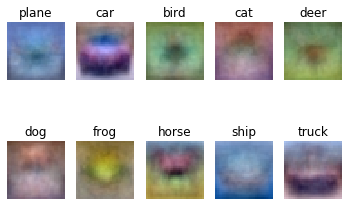

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i] - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])